In [15]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize


%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression

In [2]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_095', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']

In [3]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"

In [4]:
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res
z=20
behaviors = ['Y_pos', 'Y_neg', 'Z_pos', 'Z_neg']

# Load Neural Data

In [5]:
t0 = time.time()
brain_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201110_analysis_superfly_supervoxels/superslice_20.nii"
brain = np.array(nib.load(brain_file).get_data(), copy=True)
print(f'Duration: {time.time()-t0}')

Duration: 13.836262702941895


In [6]:
anat_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/luke.nii"
anatomy = np.array(nib.load(anat_path).get_data(), copy=True)

# Make clusters

In [7]:
def create_clusters(brain, n_clusters):
    t0 = time.time()
    clustering_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201110_analysis_superfly_supervoxels"
    super_to_cluster = brain.reshape(-1, 33840)
    connectivity = grid_to_graph(256,128)
    cluster_model = AgglomerativeClustering(n_clusters=n_clusters,
                                    memory=clustering_dir,
                                    linkage='ward',
                                    connectivity=connectivity)
    cluster_model.fit(super_to_cluster)
    print('Duration: {}'.format(time.time()-t0))
    return cluster_model

In [8]:
n_clusters = 2000
cluster_model = create_clusters(brain, n_clusters)

Duration: 65.54846930503845


# Build Flies

In [9]:
class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model.labels_==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def make_corr_map (self, n_clusters, cluster_model, behavior):
        corrs = []
        # remove zeros from correlation
        behavior_vector = flies[fly].fictrac.fictrac[behavior]
        non_zero_entries = np.where(behavior_vector != 0)[0]
        for i in range(n_clusters):
            cluster_indicies = np.where(cluster_model.labels_==i)[0]
            if len(cluster_indicies) > 2000:
                corrs.append(0)
            else:
                corrs.append(scipy.stats.pearsonr(behavior_vector[non_zero_entries],
                                                  self.cluster_signals[i,non_zero_entries])[0])
        colored_by_betas = np.zeros(256*128)
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model.labels_==cluster_num)[0]
            colored_by_betas[cluster_indicies] = corrs[cluster_num]
        colored_by_betas = colored_by_betas.reshape(256,128)
        self.maps[behavior] = colored_by_betas
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

In [10]:
class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self, z):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Velocity ###
            low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
            self.fictrac[short] = low_res_behavior#/np.std(low_res_behavior)
            
            ### Clipped Velocities ###
            self.fictrac[short + '_pos'] = np.clip(self.fictrac[short], a_min=0, a_max=None)
            self.fictrac[short + '_neg'] = np.clip(self.fictrac[short], a_min=None, a_max=0)*-1
            
            ### Strongly Clipped Velocities ###
            # excludes points even close to 0
            #self.fictrac[short + '_pos_very'] = np.clip(self.fictrac[short], a_min=0.3, a_max=None)
            #self.fictrac[short + '_neg_very'] = np.clip(self.fictrac[short], a_min=None, a_max=-0.3)*-1

            ### Acceleration ###
            high_res_behavior = self.pull_from_interp_object(interp_object, high_res_timepoints)
            self.fictrac[short + 'h'] = high_res_behavior/np.std(high_res_behavior)

            accel = scipy.signal.savgol_filter(np.diff(high_res_behavior),25,3)
            accel = np.append(accel, 0)
            interp_object = interp1d(high_res_timepoints, accel, bounds_error = False)
            acl = interp_object(self.timestamps[:,z])
            acl[-1] = 0
            self.fictrac[short + 'a'] = acl/np.std(acl)

        self.fictrac['YZ'] = np.sqrt(np.power(self.fictrac['Y'],2), np.power(self.fictrac['Z'],2))
        self.fictrac['YZh'] = np.sqrt(np.power(self.fictrac['Yh'],2), np.power(self.fictrac['Zh'],2))

In [11]:
flies = {}
for i, fly in enumerate(fly_names):
    print('==={}==='.format(fly))
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    flies[fly].load_timestamps()
    flies[fly].load_fictrac()
    flies[fly].fictrac.interp_fictrac(z)
    flies[fly].load_brain_slice()
    flies[fly].load_anatomy()
    flies[fly].get_cluster_averages(cluster_model, n_clusters)

#Correct behavior std as a pooled group
all_flies_Y = []
all_flies_Z = []
for i, fly in enumerate(fly_names):
    all_flies_Y.append(flies[fly].fictrac.fictrac['Y'])
    all_flies_Z.append(flies[fly].fictrac.fictrac['Z'])
Y_std = np.std(np.asarray(all_flies_Y).ravel())
Z_std = np.std(np.asarray(all_flies_Z).ravel())

for i, fly in enumerate(fly_names):
    for behavior in ['Y_pos', 'Y_neg', 'Z_pos', 'Z_neg']:
        if behavior in ['Y_pos', 'Y_neg']:
            flies[fly].fictrac.fictrac[behavior] = flies[fly].fictrac.fictrac[behavior]/Y_std
        if behavior in ['Z_pos', 'Z_neg']:
            flies[fly].fictrac.fictrac[behavior] = flies[fly].fictrac.fictrac[behavior]/Z_std
        flies[fly].make_corr_map(n_clusters, cluster_model, behavior)

===fly_087===

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 55.03 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.10 sec
===fly_089===

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 88.41 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.18 sec
===fly_094===

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 39.80 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.09 sec
===fly_095===

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 53.53 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.22 sec
===fly_097===

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 40.35 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.11 sec
===fly_098===

~~ load_timestamps ~~
Trying t

In [53]:
### Average outputs over flies ###

### Average Maps
MEANS = {}
for behavior in ['Y_pos', 'Y_neg', 'Z_pos', 'Z_neg']:
    mean_map = []
    for fly in fly_names:
        mean_map.append(flies[fly].maps[behavior])
    MEANS[behavior] = np.mean(np.nan_to_num(np.asarray(mean_map)), axis=0)

### Pooled behavior
pooled_behavior = {}
for j, behavior in enumerate(behaviors):
    pooled_behavior[behavior] = []
    for i,fly in enumerate(flies):
        pooled_behavior[behavior].append(flies[fly].fictrac.fictrac[behavior])
    pooled_behavior[behavior] = np.asarray(pooled_behavior[behavior]).flatten()

In [75]:
def plot_map (fig, fly, behavior, vmin, vmax, x_pos, y_pos):
    ax = fig.add_axes([x_pos,y_pos,.1,.1])
    ax.imshow(flies[fly].maps[behavior].T,vmin=vmin,vmax=vmax,cmap='seismic')
    ax.axis('off')
    
def plot_zoom_in_map (fig, behavior, x_pos, y_pos, width):
    ax = fig.add_axes([x_pos,y_pos,.05,.1])
    plt.imshow(MEANS[behavior][x-width:x+width,y-width:y+width].T, cmap='seismic', vmin=-.3, vmax=.3)
    plt.axhline(width,color='k',linestyle='--',linewidth=1)
    plt.axvline(width,color='k',linestyle='--',linewidth=1)
    #ax.axis('off')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
def plot_zoom_in_anat(fig, anatomy, x_pos, y_pos, width):
    ax = fig.add_axes([x_pos,y_pos,.05,.1])
    plt.imshow(anatomy[X_anat-width*4:X_anat+width*4,Y_anat-width*4:Y_anat+width*4,Z_anat].T,
               vmin=.1, vmax=1, cmap='gray')
    plt.axhline(width*4,color='k',linestyle='--',linewidth=1)
    plt.axvline(width*4,color='k',linestyle='--',linewidth=1)
    ax.axis('off')
    
def plot_1d_corr_scatter(fig, fly, behavior, x_pos, y_pos, signal_type):
    ax = fig.add_axes([x_pos,y_pos,.1,.05])
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    
    r = flies[fly].maps[behavior][x, y]
    
    X_var = flies[fly].fictrac.fictrac[behavior]
    
    if signal_type == 'supervoxel':
        Y_var = flies[fly].cluster_signals[flies[fly].get_cluster_id(x, y), :]
    if signal_type == 'singlevoxel':
        Y_var = flies[fly].brain[x,y,:]
    if signal_type == 'pooled':
        Y_var = pooled_activity
        X_var = pooled_behavior[behavior]
        r = MEANS[behavior][x, y]
    
    ax.plot(X_var,Y_var,'x',color='k',marker=',')
    ax.axhline(0,linewidth=1,color='k')
    
    # plot piecewise linear regression
    split = 0.5
    piece_1 = np.where((X_var > 0) & (X_var < split))[0]
    piece_2 = np.where(X_var>=split)[0]

    model_all = LinearRegression().fit(X_var.reshape(-1,1), Y_var.reshape(-1,1))
    model_1 = LinearRegression().fit(X_var[piece_1].reshape(-1,1), Y_var[piece_1].reshape(-1,1))
    model_2 = LinearRegression().fit(X_var[piece_2].reshape(-1,1), Y_var[piece_2].reshape(-1,1))

    xs = np.asarray([0,split])
    ys = model_1.predict(xs.reshape(-1,1))
    plt.plot(xs, ys*5)

    xs = np.arange(split,8,1)
    ys = model_2.predict(xs.reshape(-1,1))
    plt.plot(xs, ys*5)

    if signal_type == 'pooled':
        score_all = np.sqrt(model_all.score(X_var.reshape(-1,1), Y_var.reshape(-1,1)))
        score_1 = np.sqrt(model_1.score(X_var[piece_1].reshape(-1,1), Y_var[piece_1].reshape(-1,1)))
        score_2 = np.sqrt(model_2.score(X_var[piece_2].reshape(-1,1), Y_var[piece_2].reshape(-1,1)))
        
        plt.text(s='R_all={:.2f}'.format(score_all), x=7.2, y=1.2, fontsize=8)
        plt.text(s='R_1={:.2f}'.format(score_1), x=7.2, y=.2, fontsize=8)
        plt.text(s='R_2={:.2f}'.format(score_2), x=7.2, y=-.8, fontsize=8)
    
    ax.set_xlim(0,7)
    ax.set_ylim(-1,2)
    plt.text(s='R={:.2f}'.format(r), x=.1, y=1.2, fontsize=8)

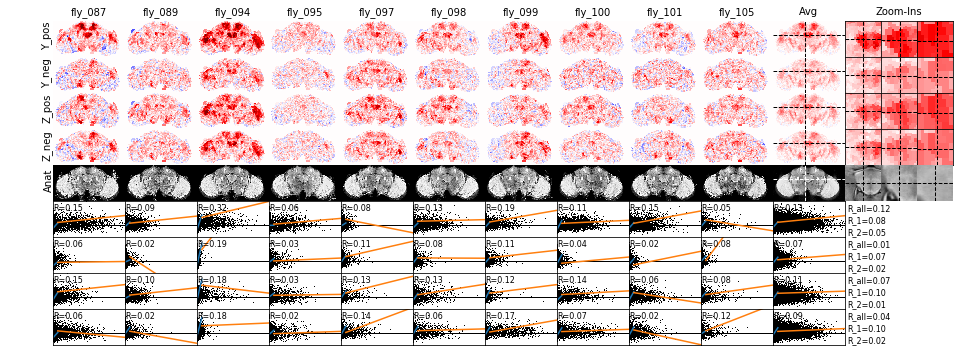

In [76]:
x=40;y=51 #medulla
x=114;y=49

fig = plt.figure(figsize=(10,10))

#######################################
### Individual fly correlation maps ###
#######################################
for i,fly in enumerate(flies):
    for j, behavior in enumerate(behaviors):
        plot_map(fig, fly, behavior, -.3, .3, 0+i*.1, 1-j*.05)
        if j==0:
            plt.title(fly, fontsize=10)
        if i==0:
            plt.text(s=behavior,x=-40,y=30,fontsize=10,rotation=90)

##################################################
### Avergage fly correlation maps and zoom-ins ###
##################################################
for j, behavior in enumerate(behaviors):
    ax = fig.add_axes([1,1-j*.05,.1,.1])
    ax.imshow(MEANS[behavior].T,vmin=-.3,vmax=.3,cmap='seismic')
    ax.axis('off')
    plt.axhline(y,color='k',linestyle='--',linewidth=1)
    plt.axvline(x,color='k',linestyle='--',linewidth=1)
    if j == 0:
        plt.title('Avg',fontsize=10)
        
    # Zoom-ins
    plot_zoom_in_map(fig, behavior, 1.1, 1-j*.05, 20)
    plot_zoom_in_map(fig, behavior, 1.15, 1-j*.05, 10)
    if j == 0:
        plt.title('Zoom-Ins',fontsize=10)
    plot_zoom_in_map(fig, behavior, 1.2, 1-j*.05, 5)

################
### Anatomys ###
################
X_anat = int(x/256*1024)
Y_anat = int(y/128*512)
Z_anat = int(z/49*256)
for i,fly in enumerate(flies):
    ax = fig.add_axes([0+i*.1,.8,.1,.1])
    ax.imshow(flies[fly].anatomy[:,:,Z_anat].T,cmap='gray')
    ax.axis('off')
    if i==0:
        plt.text(s='Anat',x=-120,y=170,fontsize=10,rotation=90)
ax = fig.add_axes([1,.8,.1,.1])
ax.imshow(anatomy[:,:,Z_anat].T,cmap='gray')
ax.axis('off')
plt.axhline(Y_anat,color='w',linestyle='--',linewidth=1)
plt.axvline(X_anat,color='w',linestyle='--',linewidth=1)
plot_zoom_in_anat(fig, anatomy, 1.1, .8, 20)
plot_zoom_in_anat(fig, anatomy, 1.15, .8, 10)
plot_zoom_in_anat(fig, anatomy, 1.2, .8, 5)

###############
### 1D Corr ###
###############

pooled_activity = []
for i,fly in enumerate(flies):
    pooled_activity.append(flies[fly].cluster_signals[flies[fly].get_cluster_id(x, y), :])
pooled_activity = np.asarray(pooled_activity).flatten()

for j, behavior in enumerate(behaviors):
    for i,fly in enumerate(flies):
        plot_1d_corr_scatter(fig, fly, behavior, 0+i*.1, .775-j*.05, 'supervoxel')
    plot_1d_corr_scatter(fig, fly, behavior, 1, .775-j*.05, 'pooled')
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr)
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [62]:
np.sqrt(0.0002190969049334912)

0.014801922339125119

In [30]:
all_flies = []
for i, fly in enumerate(fly_names):
    all_flies.append(flies[fly].fictrac.fictrac['Y'])
np.std(np.asarray(all_flies).ravel())

0.010885216617373994

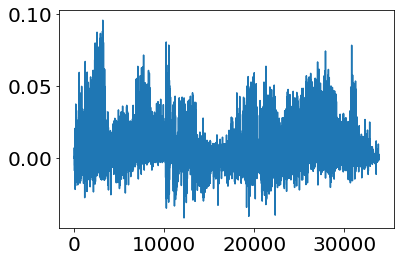

In [32]:
plt.plot(np.asarray(all_flies).ravel())

1572


(40, 60)

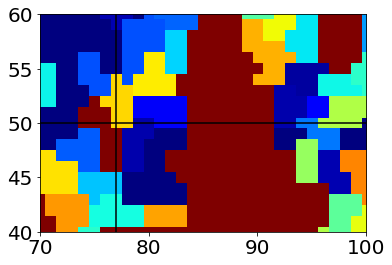

In [93]:
x=77;y=50

ax_vec = x*128 + y

for i in range(n_clusters):
    if ax_vec in flies['fly_087'].cluster_indicies[i]:
        print(i)
        
plt.imshow(flies['fly_087'].maps['Y_pos'].T,cmap='jet',vmin=0,vmax=.05)
plt.axvline(x,color='k')
plt.axhline(y,color='k')
plt.xlim(70,100)
plt.ylim(40,60)

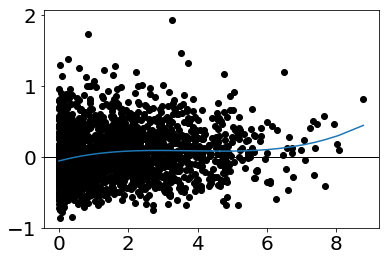

In [96]:
fly = 'fly_087'
behavior = 'Y_pos'

Y_var = flies[fly].cluster_signals[flies[fly].get_cluster_id(x, y), :]
X_var = flies[fly].fictrac.fictrac[behavior]

non_zero_entries = np.where(X_var != 0)[0]
X_var = X_var[non_zero_entries]
Y_var = Y_var[non_zero_entries]

plt.plot(X_var,Y_var,'x',color='k',marker='o')
plt.axhline(0,linewidth=1,color='k')

inds = np.argsort(X_var)
X_var = X_var[inds]
Y_var = Y_var[inds]
spl = UnivariateSpline(X_var, Y_var)
spl.set_smoothing_factor(280)
plt.plot(X_var, spl(X_var))


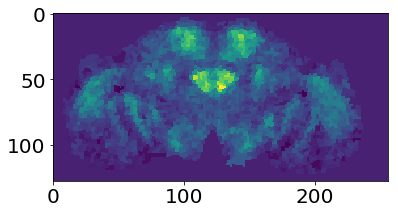

In [37]:
plt.imshow(MEANS['Y_pos'].T)

In [ ]:
def plot_map (fig, fly, behavior, vmin, vmax, x_pos, y_pos):
    ax = fig.add_axes([x_pos,y_pos,.1,.1])
    ax.imshow(flies[fly].maps[behavior].T,vmin=vmin,vmax=vmax,cmap='seismic')
    ax.axis('off')
    
def plot_zoom_in_map (fig, behavior, x_pos, y_pos, width):
    ax = fig.add_axes([x_pos,y_pos,.05,.1])
    plt.imshow(MEANS[behavior][x-width:x+width,y-width:y+width].T, cmap='seismic', vmin=-.3, vmax=.3)
    plt.axhline(width,color='k',linestyle='--',linewidth=1)
    plt.axvline(width,color='k',linestyle='--',linewidth=1)
    #ax.axis('off')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
def plot_zoom_in_anat(fig, anatomy, x_pos, y_pos, width):
    ax = fig.add_axes([x_pos,y_pos,.05,.1])
    plt.imshow(anatomy[X_anat-width*4:X_anat+width*4,Y_anat-width*4:Y_anat+width*4,Z_anat].T,
               vmin=.1, vmax=1, cmap='gray')
    plt.axhline(width*4,color='k',linestyle='--',linewidth=1)
    plt.axvline(width*4,color='k',linestyle='--',linewidth=1)
    ax.axis('off')
    
def plot_1d_corr_scatter(fig, fly, behavior, x_pos, y_pos, signal_type):
    ax = fig.add_axes([x_pos,y_pos,.1,.05])
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    if signal_type == 'supervoxel':
        Y_var = flies[fly].cluster_signals[flies[fly].get_cluster_id(x, y), :]
    if signal_type == 'singlevoxel':
        Y_var = flies[fly].brain[x,y,:]
    
    X_var = flies[fly].fictrac.fictrac[behavior]

    ax.plot(X_var,Y_var,'x',color='k',marker=',')
    ax.axhline(0,linewidth=1,color='k')
    
    split = 0.5
    piece_1 = np.where((X_var > 0) & (X_var < split))[0]
    piece_2 = np.where(X_var>=split)[0]

    model_all = LinearRegression().fit(X_var.reshape(-1,1), Y_var.reshape(-1,1))
    model_1 = LinearRegression().fit(X_var[piece_1].reshape(-1,1), Y_var[piece_1].reshape(-1,1))
    model_2 = LinearRegression().fit(X_var[piece_2].reshape(-1,1), Y_var[piece_2].reshape(-1,1))
    
    #plt.plot(X_var, Y_var, marker='o', linestyle= '')
    #xs = np.arange(0,8,1)
    #ys = model_all.predict(xs.reshape(-1,1))
    #plt.plot(xs, ys)

    xs = np.asarray([0,split])
    ys = model_1.predict(xs.reshape(-1,1))
    plt.plot(xs, ys*5)

    xs = np.arange(split,8,1)
    ys = model_2.predict(xs.reshape(-1,1))
    plt.plot(xs, ys*5)
    

    
#     non_zero_entries = np.where(X_var != 0)[0]
#     X_var = X_var[non_zero_entries]
#     Y_var = Y_var[non_zero_entries]
        


#     inds = np.argsort(X_var)
#     X_var = X_var[inds]
#     Y_var = Y_var[inds]
#     spl = UnivariateSpline(X_var, Y_var)
#     spl.set_smoothing_factor(100000000)
#     plt.plot(X_var, spl(X_var)*5)
    
#     num_bins = 10
#     min_bin = 0
#     max_bin = 5
    
#     binned = scipy.stats.binned_statistic(x=flies[fly].fictrac.fictrac[behavior],
#                                           values=neural_data,
#                                           statistic='mean', bins=num_bins, range=(min_bin,max_bin))
#     binned_std = scipy.stats.binned_statistic(x=flies[fly].fictrac.fictrac[behavior],
#                                               values=neural_data,
#                                               statistic='std', bins=num_bins, range=(min_bin,max_bin))
#     binned_cnt = scipy.stats.binned_statistic(x=flies[fly].fictrac.fictrac[behavior],
#                                               values=neural_data,
#                                               statistic='count', bins=num_bins, range=(min_bin,max_bin))
#     centers = (binned.bin_edges[:-1] + binned.bin_edges[1:]) / 2
#     binned_SE = binned_std.statistic/np.sqrt(binned_cnt.statistic)
    
    #ax.plot(centers,binned.statistic,color='red',linewidth=1,marker='o',markersize=1)
    #ax.fill_between(centers, binned.statistic-binned_SE, binned.statistic+binned_SE,alpha=.3,color='red')
    
    #ax.plot(centers,binned.statistic*5,color='red',linewidth=1,marker='o',markersize=1)
    
    ax.set_xlim(0,7)
    ax.set_ylim(-1,2)
    
    r2 = flies[fly].maps[behavior][x, y]
    plt.text(s='{:.2f}'.format(r2), x=0, y=3.5, fontsize=8)

In [167]:
fly = 'fly_087'
behavior = 'Y_pos'

Y_var = flies[fly].cluster_signals[flies[fly].get_cluster_id(x, y), :]
X_var = flies[fly].fictrac.fictrac[behavior]

piece_1 = np.where((X_var > 0) & (X_var < 1))[0]
piece_2 = np.where(X_var>=1)[0]

model_all = LinearRegression().fit(X_var.reshape(-1,1), Y_var.reshape(-1,1))
model_1 = LinearRegression().fit(X_var[piece_1].reshape(-1,1), Y_var[piece_1].reshape(-1,1))
model_2 = LinearRegression().fit(X_var[piece_2].reshape(-1,1), Y_var[piece_2].reshape(-1,1))



In [150]:
np.arange(0,8,1)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [141]:
model.predict(np.asarray(6).reshape(-1,1))

array([[0.19718977]])

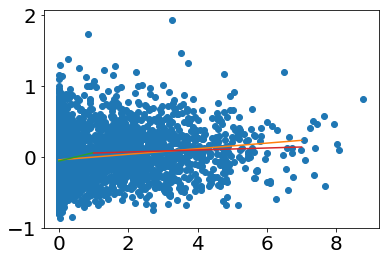

In [168]:
plt.plot(X_var, Y_var, marker='o', linestyle= '')
xs = np.arange(0,8,1)
ys = model_all.predict(xs.reshape(-1,1))
plt.plot(xs, ys)

xs = np.asarray([0,1])
ys = model_1.predict(xs.reshape(-1,1))
plt.plot(xs, ys)

xs = np.arange(1,8,1)
ys = model_2.predict(xs.reshape(-1,1))
plt.plot(xs, ys)

In [163]:
xs

array([0])

In [152]:
model.predict(xs.reshape(-1,1))

array([[-3.92674034e-02],
       [ 1.42124768e-04],
       [ 3.95516529e-02],
       [ 7.89611811e-02],
       [ 1.18370709e-01],
       [ 1.57780237e-01],
       [ 1.97189766e-01],
       [ 2.36599294e-01]])

In [132]:
model.coef_

array([[0.03940953]])

In [131]:
model.intercept_

array([-0.0392674])

In [126]:
fly = 'fly_087'
behavior = 'Y_pos'

Y_var = flies[fly].cluster_signals[flies[fly].get_cluster_id(x, y), :]
X_var = flies[fly].fictrac.fictrac[behavior]

piece_1 = np.where((X_var > 0) & (X_var < 1))[0]
piece_2 = np.where(X_var>=1)[0]
# X_var = X_var[non_zero_entries]
# Y_var = Y_var[non_zero_entries]

# plt.plot(X_var,Y_var,'x',color='k',marker='o')
# plt.axhline(0,linewidth=1,color='k')

# inds = np.argsort(X_var)
# X_var = X_var[inds]
# Y_var = Y_var[inds]
# spl = UnivariateSpline(X_var, Y_var)
# spl.set_smoothing_factor(280)
# plt.plot(X_var, spl(X_var))


In [127]:
len(piece_2)

1123

In [125]:
len(piece_1)

1186

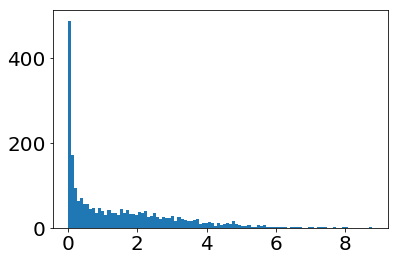

In [102]:
this, _, _ =plt.hist(X_var,bins=100);

In [105]:
threshold_triangle(this)

14.296875

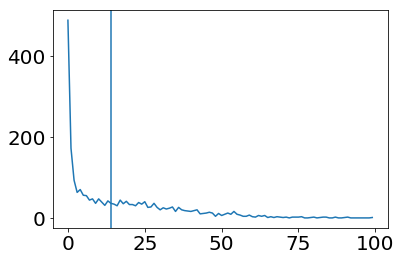

In [106]:
plt.plot(this)
plt.axvline(14)

In [106]:
flies['fly_087'].maps['Y_pos'].shape

(256, 128)

In [116]:
anatomy.shape

(1024, 512, 256)

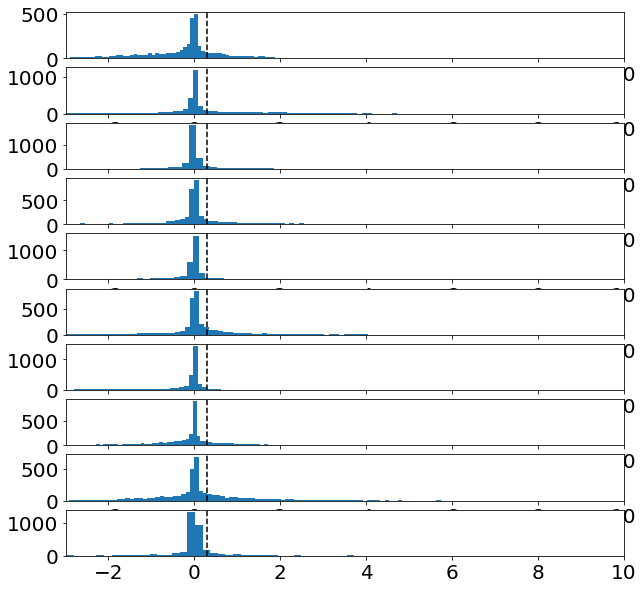

In [69]:
fig = plt.figure(figsize=(10,10))

for i,fly in enumerate(fly_names):
    plt.subplot(10,1,i+1)
    plt.hist(flies[fly].fictrac.fictrac['Z'],bins=100);
    plt.xlim(-3,10)
    plt.axvline(.3,color='k',linestyle='--')

In [ ]:
def load_maps2 (self):
        glm_Y-applied-meanbrain.nii
    def load_maps (self):
        try:
            to_load = os.path.join(self.dir, 'glm', '20201009_Y.nii')
            self.Y_glm_map = np.array(nib.load(to_load).get_data(), copy=True)

            to_load = os.path.join(self.dir, 'glm', '20201009_Z.nii')
            self.Z_glm_map = np.array(nib.load(to_load).get_data(), copy=True)
            print('loaded 9th maps')
        except:
            to_load = os.path.join(self.dir, 'glm', '20201002_Y.nii')
            self.Y_glm_map = np.array(nib.load(to_load).get_data(), copy=True)

            to_load = os.path.join(self.dir, 'glm', '20201002_Z.nii')
            self.Z_glm_map = np.array(nib.load(to_load).get_data(), copy=True)
            print('loaded 2nd maps')
            
        to_load = os.path.join(self.dir, 'corr', '20201104_corr_Y.nii')
        self.Y_corr_map = np.array(nib.load(to_load).get_data(), copy=True)

        to_load = os.path.join(self.dir, 'corr', '20201104_corr_Z_abs.nii')
        self.Z_corr_map = np.array(nib.load(to_load).get_data(), copy=True)
        
            def load_cross_corr_map (self):
        load_file = os.path.join(self.dir,'20201104_cross_corr_times.npy')
        lag_time_peak_all = np.load(load_file)

        load_file = os.path.join(self.dir,'20201104_cross_corr_values.npy')
        lag_corr_values_all = np.load(load_file)

        lag_time_peak_ = np.reshape(lag_time_peak_all, (49, 256,128))
        lag_corr_values_ = np.reshape(lag_corr_values_all, (49, 256,128))

In [77]:
single_maps_shared_clusters = []
for fly_idx, fly in enumerate(fly_names):
    print(fly)
    neural_data = brain[:,:,:,fly_idx].reshape(-1, 3384)

    signals = []
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(model.labels_==cluster_num)[0]
        mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
        signals.append(mean_signal)
    signals=np.asarray(signals)

    corrs = []
    for i in range(n_clusters):
        corrs.append(scipy.stats.pearsonr(flies[fly].fictrac.fictrac['Y'], signals[i,:])[0])

    colored_by_betas = np.zeros(256*128)
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(model.labels_==cluster_num)[0]
        colored_by_betas[cluster_indicies] = corrs[cluster_num] #assign corrs here instead.
    colored_by_betas = colored_by_betas.reshape(256,128)
    single_maps_shared_clusters.append(colored_by_betas)

fly_087
fly_089
fly_094
fly_095
fly_097
fly_098
fly_099
fly_100
fly_101
fly_105


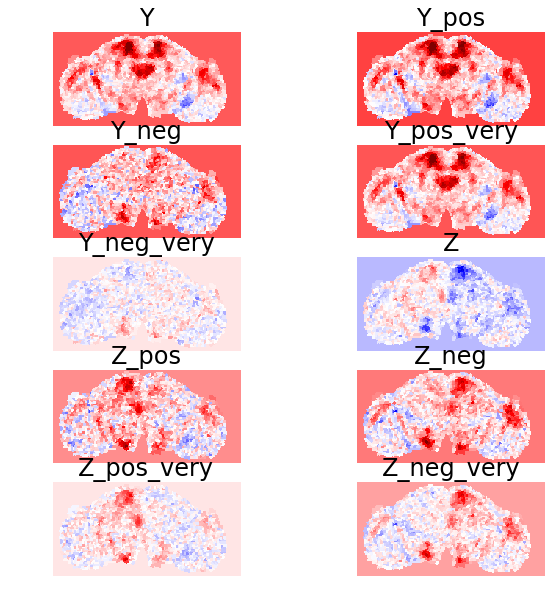

In [176]:
plt.figure(figsize=(10,10))
for i,behavior in enumerate(['Y', 'Y_pos', 'Y_neg', 'Y_pos_very', 'Y_neg_very',
                 'Z', 'Z_pos', 'Z_neg', 'Z_pos_very', 'Z_neg_very']):
    plt.subplot(5,2,i+1)
    plt.imshow(flies['fly_087'].maps[behavior].T,vmin=-.3,vmax=.3,cmap='seismic')
    plt.axis('off')
    plt.title(behavior)

# Load Behavior and Neural Data

In [4]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"

In [38]:
fly = "fly_094"
directory = os.path.join(dataset_path,fly,'func_0')

In [39]:
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac_raw = bbb.load_fictrac(os.path.join(directory, 'fictrac'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 1.25 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 2.85 sec


In [40]:
brain_file = os.path.join(directory, 'brain_zscored_green_high_pass_masked.nii')
brain = np.array(nib.load(brain_file).get_data(), copy=True)

In [73]:
to_load = os.path.join(directory, 'glm', '20201002_Y.nii')
Y_map = np.array(nib.load(to_load).get_data(), copy=True)

to_load = os.path.join(directory, 'glm', '20201002_Z.nii')
Z_map = np.array(nib.load(to_load).get_data(), copy=True)

to_load = os.path.join(directory, 'corr', '20201104_corr_Y.nii')
Y_corr_map = np.array(nib.load(to_load).get_data(), copy=True)

to_load = os.path.join(directory, 'corr', '20201104_corr_Z_abs.nii')
Z_corr_map = np.array(nib.load(to_load).get_data(), copy=True)

In [42]:
to_load = os.path.join(dataset_path, fly, 'anat_0', 'moco', 'anat_red_clean_sharp.nii')
anatomy = np.array(nib.load(to_load).get_data(), copy=True)

In [ ]:
load_file = os.path.join(dataset_path,fly,'func_0','20201104_cross_corr_times.npy')
lag_time_peak_all = np.load(load_file)

load_file = os.path.join(dataset_path,fly,'func_0','20201104_cross_corr_values.npy')
lag_corr_values_all = np.load(load_file)

lag_time_peak_ = np.reshape(lag_time_peak_all, (49, 256,128))
lag_corr_values_ = np.reshape(lag_corr_values_all, (49, 256,128))

# Load and process UMAP

In [43]:
### Load Data ###

umap_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201031_UMAP/'
umap_file = os.path.join(umap_dir, 'luke_fictrac_TREBLE_layout_win14_102520.txt')
umap_raw = np.genfromtxt(umap_file, usecols=(0,1,-2,-1), dtype=str,skip_header=1)

In [44]:
### Grab fly94 ###

fly94_idx = np.where(umap_raw[:,-1]=='fictrac-20200620_122048_fly94')[0]
umap_fly94 = umap_raw[fly94_idx,:3].astype(float)

In [45]:
def interp_umap(z):
    ### X-values ###
    interp_object = interp1d(umap_fly94[:,-1]*1000, umap_fly94[:,0], bounds_error = False)
    umap_x = interp_object(timestamps[:,z])
    np.nan_to_num(umap_x, copy=False);

    ### Y-values ###
    interp_object = interp1d(umap_fly94[:,-1]*1000, umap_fly94[:,1], bounds_error = False)
    umap_y = interp_object(timestamps[:,z])
    np.nan_to_num(umap_y, copy=False);
    
    return umap_x, umap_y

In [11]:
#umap_x, umap_y = interp_umap(z=40)

# Process Fictrac

In [46]:
def make_interp_object(fictrac_raw, behavior):
    # Create camera timepoints
    fps=50
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    expt_len = 1000*30*60
    x_original = np.arange(0,expt_len,camera_rate)
    
    # Smooth raw fictrac data
    fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(fictrac_raw[behavior]),25,3)
    
    # Create interp object with camera timepoints
    fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
    return fictrac_interp_object

def pull_from_interp_object(interp_object, timepoints):
    new_interp = interp_object(timepoints)
    np.nan_to_num(new_interp, copy=False);
    return new_interp

def interp_fictrac(z):
    behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
    fictrac = {}

    for behavior, short in zip(behaviors, shorts):
        interp_object = make_interp_object(fictrac_raw, behavior)
        fictrac[short + 'i'] = interp_object

        ### Velocity ###
        low_res_behavior = pull_from_interp_object(interp_object, timestamps[:,z])
        fictrac[short] = low_res_behavior/np.std(low_res_behavior)

        ### Acceleration ###
        high_res_behavior = pull_from_interp_object(interp_object, high_res_timepoints)
        fictrac[short + 'h'] = high_res_behavior/np.std(high_res_behavior)

        accel = scipy.signal.savgol_filter(np.diff(high_res_behavior),25,3)
        accel = np.append(accel, 0)
        interp_object = interp1d(high_res_timepoints, accel, bounds_error = False)
        acl = interp_object(timestamps[:,z])
        acl[-1] = 0
        fictrac[short + 'a'] = acl/np.std(acl)

    fictrac['YZ'] = np.sqrt(np.power(fictrac['Y'],2), np.power(fictrac['Z'],2))
    fictrac['YZh'] = np.sqrt(np.power(fictrac['Yh'],2), np.power(fictrac['Zh'],2))
    
    return fictrac

In [47]:
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res
fictrac = interp_fictrac(z=40)

In [14]:
# fig = plt.figure(figsize=(10,10))
# plt.plot(high_res_timepoints, fictrac['Yh'],label='high_res')
# plt.plot(timestamps[:,z], fictrac['Y'],label='low_res')
# plt.plot(timestamps[:,z],fictrac['Ya'],label='accel')
# plt.xlim(50000,60000)
# plt.legend()

# Identify Bouts

In [48]:
def find_bouts():
    expt_len = 1000*30*60
    resolution = 10
    high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

    behavior = 'Yh'

    B_THRESHOLD = np.std(fictrac[behavior])/4
    ALIVE_TIME = 1000 # in ms
    DEAD_TIME = 1000 # in ms

    state = 'quiescent'
    up_streak = 0
    down_streak = 0
    BOUTS = []
    ALIVE_TIME = int(ALIVE_TIME/resolution)
    DEAD_TIME = int(DEAD_TIME/resolution)

    for i in range(len(fictrac[behavior])):
        # If high behavior, reset down_streak, and add 1 to up_streak
        if fictrac[behavior][i] > B_THRESHOLD:
            down_streak = 0
            up_streak += 1
        else:
            up_streak = 0
            down_streak += 1

        if state == 'quiescent':
            if up_streak >= ALIVE_TIME:
                state = 'moving'
                BOUTS.append({'start': i-ALIVE_TIME})
        elif state == 'moving':
            if down_streak >= DEAD_TIME:
                state = 'quiescent'
                BOUTS[-1]['end'] = i-DEAD_TIME
    BOUTS = [bout for bout in BOUTS if 'end' in bout]
    print('Found {} bouts'.format(len(BOUTS)))

    ### Clean Start Bouts
    # remove bouts that have behavior too close *before* them
    before = 3000 # in ms
    before = int(before/10)
    start_bouts=[bout for bout in BOUTS if np.mean(np.abs(fictrac['Yh'][bout['start']-before:bout['start']])) < .2]
    print('Remaining start_bouts post-cleaning: {}'.format(np.shape(start_bouts)[0]))

    ### Clean Stop Bouts
    # remove bouts that have behavior too close *after* them
    before = 4000 # in ms
    before = int(before/10)
    stop_bouts=[bout for bout in BOUTS if np.mean(np.abs(fictrac['Yh'][bout['end']:bout['end']+before])) < .2]
    print('Remaining stop_bouts bouts post-cleaning: {}'.format(np.shape(stop_bouts)[0]))
    return start_bouts, stop_bouts

# Identify behavior times

In [49]:
def get_behavior_times():
    # create bounding boxes
    forward_min = 2
    forward_max = 6
    forward_width = 1

    rotation_min = 2
    rotation_max = 12
    rotation_forward_bias = 2
    rotation_reverse_bias = 0

    stop_r = 0.2

    f1 = np.where(fictrac['Y']>forward_min)[0]
    f2 = np.where(np.abs(fictrac['Z'])<forward_width)[0]
    f3 = np.where(fictrac['Y']<forward_max)[0]
    forward_times = [i for i in f1 if i in f2 and i in f3]

    r1 = np.where(fictrac['Z']>rotation_min)[0]
    r2 = np.where(fictrac['Z']<rotation_max)[0]
    r3 = np.where(fictrac['Y']>rotation_reverse_bias)[0]
    r4 = np.where(fictrac['Y']<rotation_forward_bias)[0]
    rotation_pos_times = [i for i in r1 if i in r2 and i in r3 and i in r4]

    r1 = np.where(fictrac['Z']<-rotation_min)[0]
    r2 = np.where(fictrac['Z']>-rotation_max)[0]
    r3 = np.where(fictrac['Y']>rotation_reverse_bias)[0]
    r4 = np.where(fictrac['Y']<rotation_forward_bias)[0]
    rotation_neg_times = [i for i in r1 if i in r2 and i in r3 and i in r4]

    rotation_times = rotation_pos_times + rotation_neg_times

    stop_times = np.where(fictrac['Y']**2 + fictrac['Z']**2 < stop_r**2)[0]

    print(len(forward_times), len(rotation_pos_times), len(rotation_neg_times), len(stop_times), len(rotation_times))
    return forward_times, rotation_pos_times, stop_times

# Cross-Corr

In [50]:
def calc_cross_corr():
    cross_corr_shifts = list(range(-1000,1000,10)) # in ms
    cross_corr = {}
    for behavior in ['Yi', 'Zi']:
        fictrac_shifts = []
        for shift in cross_corr_shifts:
            fictrac_interp = np.nan_to_num(fictrac[behavior](timestamps[:,z]+shift), copy=False);
            fictrac_shifts.append(scipy.stats.pearsonr(fictrac_interp, neural_data)[0])
        cross_corr[behavior] = fictrac_shifts
    return cross_corr, cross_corr_shifts

# Straightness Metric

In [51]:
def calc_straightness():
    include_r = 3
    include_times = np.where(fictrac['Y']**2 + fictrac['Z']**2 > include_r**2)[0]
    straightness = fictrac['Y'][include_times]-np.abs(fictrac['Z'][include_times])
    fictrac['Straightness'] = straightness
    return include_times

# Plot Figs

In [52]:
def bin_pc(pc, num_bins_x, num_bins_y, idx_x ,idx_y):
    pc_binned = []
    pc_std = []
    pc_count = []
    pc_var = []
    for i in range(num_bins_x):
        mask_x = (idx_x == i)
        for j in range(num_bins_y):
            mask_y = (idx_y == j)
            mask = mask_x & mask_y
            pc_binned.append(np.mean(pc[mask]))
            pc_std.append(np.std(pc[mask]))
            pc_count.append(np.count_nonzero(~np.isnan(pc[mask])))
            pc_var.append(np.var(pc[mask]))
    pc_binned = np.flip(np.reshape(pc_binned,(num_bins_x, num_bins_y)).T,0)
    pc_std = np.flip(np.reshape(pc_std,(num_bins_x, num_bins_y)).T,0)
    pc_count = np.flip(np.reshape(pc_count,(num_bins_x, num_bins_y)).T,0)
    pc_var = np.flip(np.reshape(pc_var,(num_bins_x, num_bins_y)).T,0)
    pcs_binned = {'pc_binned': pc_binned,
                  'pc_std': pc_std,
                  'pc_count':pc_count,
                  'pc_var':pc_var}
    return pcs_binned

def bin_2D_plot(x_data, y_data, value_data, num_bins_x, num_bins_y, start_x, end_x, start_y, end_y):
    # Define bins
    bins_x, bins_y = np.linspace(start_x,end_x,num_bins_x), np.linspace(start_y,end_y,num_bins_y)

    # Assign fictrac values to bin numbers
    idx_x, idx_y = np.digitize(x_data,bins_x), np.digitize(y_data,bins_y)

    test = bin_pc(neural_data, num_bins_x, num_bins_y, idx_x ,idx_y)
    return test['pc_binned'], bins_x, bins_y

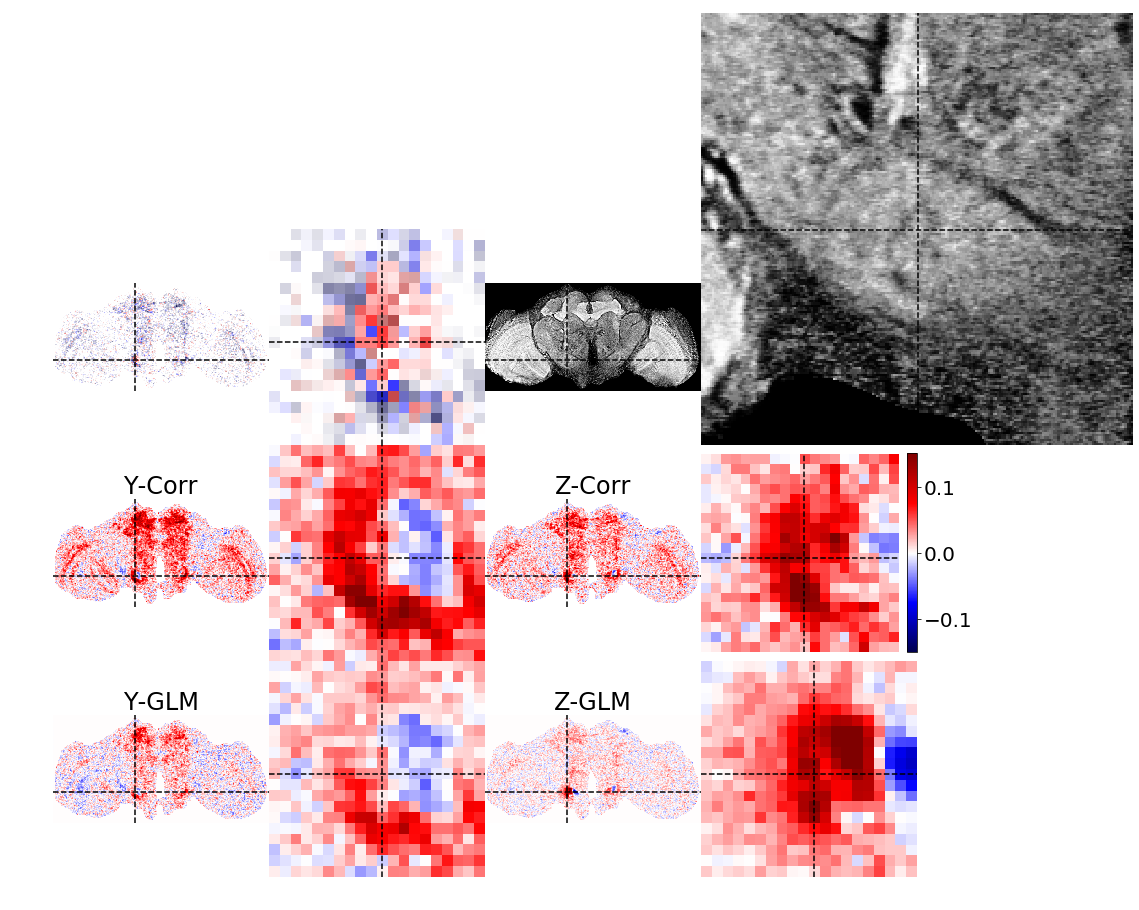

In [68]:
### Can look for a good voxel here ###

#x=106;y=90;z=30 - 1 # Dark DN spot
#x=106;y=91;z=30 - 1 # Dark DN spot neighbor
#x=130;y=50;z=7 -1 # PB
#x=141;y=47;z=22 -1 # FB
#x=64;y=85;z=30 - 1 #lobula
#x=31;y=55;z=30 - 1 #medulla
#x=99;y=24;z=30 - 1 #superior near MB
#x=87;y=36;z=30 - 1 #MB
#x=108;y=48;z=23 - 1 #FB
#x=114;y=54;z=23 - 1 #FB, different layer
x=123;y=63;z=23 - 1 #nodulus
x=124;y=63;z=23 - 1 #nodulus2
x=147;y=39;z=23 - 1 #dark spot near FB
x=145;y=37;z=23 - 1 #light spot near FB
x=104;y=70;z=37 - 1 #light spot
x=115;y=85;z=16 - 1 #some commisure
x=80;y=45;z=16 - 1 #general neuropil
x=71;y=56;z=16 - 1 #general neuropil
x=30;y=68;z=21 - 1 #medula
x=28;y=51;z=21 - 1 #medula
x=32;y=53;z=21 - 1 #medula
x=127;y=32;z=7 - 1 #near PB
x=133;y=48;z=7 - 1 #PB
x=142;y=54;z=7 - 1 #PB
x=134;y=30;z=27 - 1 #MB
x=128;y=61;z=27 - 1 #nodulus
x=97;y=91;z=31 - 1 #red cross corr spot



fig = plt.figure(figsize=(10,10))
width = 10
vmin = -0.0002
vmax = 0.0002
ax = fig.add_axes([0,1.4,.3,.3])
plt.axis('off')
plt.imshow(Y_map[:,:,z].T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.axhline(y,color='k',linestyle='--')
plt.axvline(x,color='k',linestyle='--')
plt.title('Y-GLM')
ax = fig.add_axes([.3,1.4,.3,.3])
plt.axis('off')
plt.imshow(Y_map[x-width:x+width,y-width:y+width,z].T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.axhline(width,color='k',linestyle='--')
plt.axvline(width,color='k',linestyle='--')
ax = fig.add_axes([.6,1.4,.3,.3])
plt.axis('off')
plt.title('Z-GLM')
plt.imshow(Z_map[:,:,z].T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.axhline(y,color='k',linestyle='--')
plt.axvline(x,color='k',linestyle='--')
ax = fig.add_axes([.9,1.4,.3,.3])
plt.axis('off')
plt.imshow(Z_map[x-width:x+width,y-width:y+width,z].T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.axhline(width,color='k',linestyle='--')
plt.axvline(width,color='k',linestyle='--')
plt.subplots_adjust(wspace=0, hspace=0)

############################
### Brain voxel map corr ###
############################
width = 10
vmin = -0.15
vmax = 0.15

ax = fig.add_axes([0,1.7,.3,.3])
plt.axis('off')
plt.imshow(Y_corr_map[:,:,z].T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.axhline(y,color='k',linestyle='--')
plt.axvline(x,color='k',linestyle='--')
plt.title('Y-Corr')
ax = fig.add_axes([.3,1.7,.3,.3])
plt.axis('off')
plt.imshow(Y_corr_map[x-width:x+width,y-width:y+width,z].T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.axhline(width,color='k',linestyle='--')
plt.axvline(width,color='k',linestyle='--')
ax = fig.add_axes([.6,1.7,.3,.3])
plt.axis('off')
plt.title('Z-Corr')
plt.imshow(Z_corr_map[:,:,z].T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.axhline(y,color='k',linestyle='--')
plt.axvline(x,color='k',linestyle='--')
ax = fig.add_axes([.9,1.7,.3,.3])
plt.axis('off')
plt.imshow(Z_corr_map[x-width:x+width,y-width:y+width,z].T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.axhline(width,color='k',linestyle='--')
plt.axvline(width,color='k',linestyle='--')
plt.subplots_adjust(wspace=0, hspace=0)
plt.colorbar(fraction=0.046, pad=0.04)
#ax = fig.add_axes([1.2,1.7,.3,.3])
#fig.colorbar(for_colorbar, ax=ax)

###############
### Anatomy ###
###############
width = 100
ax = fig.add_axes([.6,2,.3,.3])
X_anat = int(x/Y_map.shape[0]*anatomy.shape[0])
Y_anat = int(y/Y_map.shape[1]*anatomy.shape[1])
Z_anat = int(z/Y_map.shape[2]*anatomy.shape[2])
plt.axis('off')
plt.imshow(anatomy[:,:,Z_anat].T, cmap='gray')
plt.axhline(Y_anat,color='k',linestyle='--')
plt.axvline(X_anat,color='k',linestyle='--')
ax = fig.add_axes([.9,2,.6,.6])
plt.axis('off')
plt.imshow(anatomy[X_anat-width:X_anat+width,Y_anat-width:Y_anat+width,Z_anat].T, cmap='gray')
plt.axhline(width,color='k',linestyle='--')
plt.axvline(width,color='k',linestyle='--')

######################
### Cross-Corr MAP ###
######################
width = 10

ax = fig.add_axes([0,2,.3,.3])
alphas = Normalize(.02, .15, clip=True)(np.abs(lag_corr_values_[z,:,:]))
alphas = np.clip(alphas, 0, 1)
colors = Normalize(-300, 300)(lag_time_peak_[z,:,:])
cmap = plt.cm.seismic
colors = cmap(colors)
colors[..., -1] = alphas
to_plot = np.swapaxes(colors,0,1)
plt.imshow(to_plot)
plt.axis('off')
plt.axhline(y,color='k',linestyle='--')
plt.axvline(x,color='k',linestyle='--')
#zoom
ax = fig.add_axes([.3,2,.3,.3])
plt.axis('off')
plt.imshow(to_plot[y-width:y+width,x-width:x+width])
plt.axhline(width,color='k',linestyle='--')
plt.axvline(width,color='k',linestyle='--')

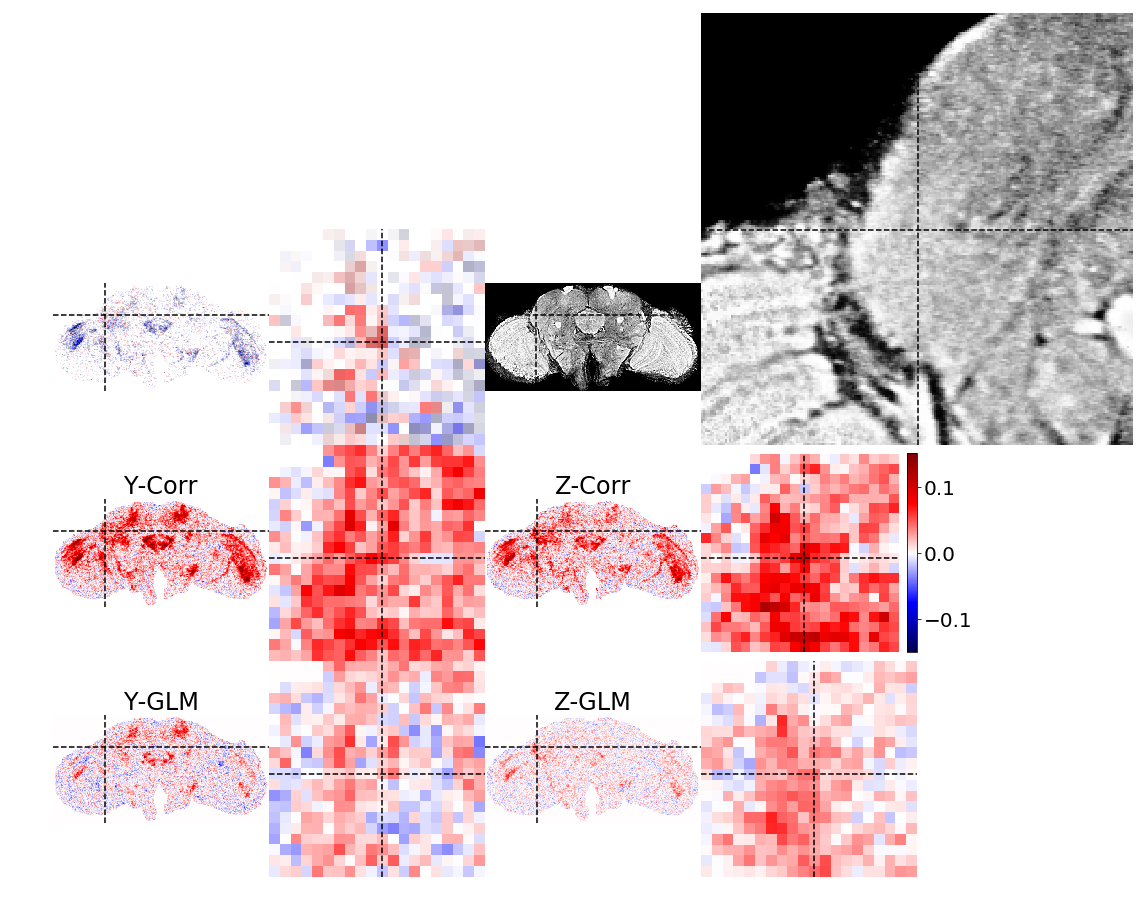

In [84]:
### Can look for a good voxel here ###

#x=106;y=90;z=30 - 1 # Dark DN spot
#x=106;y=91;z=30 - 1 # Dark DN spot neighbor
#x=130;y=50;z=7 -1 # PB
#x=141;y=47;z=22 -1 # FB
#x=64;y=85;z=30 - 1 #lobula
#x=31;y=55;z=30 - 1 #medulla
#x=99;y=24;z=30 - 1 #superior near MB
#x=87;y=36;z=30 - 1 #MB
#x=108;y=48;z=23 - 1 #FB
#x=114;y=54;z=23 - 1 #FB, different layer
x=123;y=63;z=23 - 1 #nodulus
x=124;y=63;z=23 - 1 #nodulus2
x=147;y=39;z=23 - 1 #dark spot near FB
x=145;y=37;z=23 - 1 #light spot near FB
x=104;y=70;z=37 - 1 #light spot
x=115;y=85;z=16 - 1 #some commisure
x=80;y=45;z=16 - 1 #general neuropil
x=71;y=56;z=16 - 1 #general neuropil
x=30;y=68;z=21 - 1 #medula
x=28;y=51;z=21 - 1 #medula
x=32;y=53;z=21 - 1 #medula
x=127;y=32;z=7 - 1 #near PB
x=133;y=48;z=7 - 1 #PB
x=142;y=54;z=7 - 1 #PB
x=134;y=30;z=27 - 1 #MB
x=128;y=61;z=27 - 1 #nodulus
x=97;y=90;z=31 - 1 #red cross corr spot
x=61;y=38;z=20 - 1 #red cross corr spot



fig = plt.figure(figsize=(10,10))
width = 10
vmin = -0.0002
vmax = 0.0002
ax = fig.add_axes([0,1.4,.3,.3])
plt.axis('off')
plt.imshow(Y_map[:,:,z].T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.axhline(y,color='k',linestyle='--')
plt.axvline(x,color='k',linestyle='--')
plt.title('Y-GLM')
ax = fig.add_axes([.3,1.4,.3,.3])
plt.axis('off')
plt.imshow(Y_map[x-width:x+width,y-width:y+width,z].T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.axhline(width,color='k',linestyle='--')
plt.axvline(width,color='k',linestyle='--')
ax = fig.add_axes([.6,1.4,.3,.3])
plt.axis('off')
plt.title('Z-GLM')
plt.imshow(Z_map[:,:,z].T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.axhline(y,color='k',linestyle='--')
plt.axvline(x,color='k',linestyle='--')
ax = fig.add_axes([.9,1.4,.3,.3])
plt.axis('off')
plt.imshow(Z_map[x-width:x+width,y-width:y+width,z].T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.axhline(width,color='k',linestyle='--')
plt.axvline(width,color='k',linestyle='--')
plt.subplots_adjust(wspace=0, hspace=0)

############################
### Brain voxel map corr ###
############################
width = 10
vmin = -0.15
vmax = 0.15

ax = fig.add_axes([0,1.7,.3,.3])
plt.axis('off')
plt.imshow(Y_corr_map[:,:,z].T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.axhline(y,color='k',linestyle='--')
plt.axvline(x,color='k',linestyle='--')
plt.title('Y-Corr')
ax = fig.add_axes([.3,1.7,.3,.3])
plt.axis('off')
plt.imshow(Y_corr_map[x-width:x+width,y-width:y+width,z].T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.axhline(width,color='k',linestyle='--')
plt.axvline(width,color='k',linestyle='--')
ax = fig.add_axes([.6,1.7,.3,.3])
plt.axis('off')
plt.title('Z-Corr')
plt.imshow(Z_corr_map[:,:,z].T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.axhline(y,color='k',linestyle='--')
plt.axvline(x,color='k',linestyle='--')
ax = fig.add_axes([.9,1.7,.3,.3])
plt.axis('off')
plt.imshow(Z_corr_map[x-width:x+width,y-width:y+width,z].T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.axhline(width,color='k',linestyle='--')
plt.axvline(width,color='k',linestyle='--')
plt.subplots_adjust(wspace=0, hspace=0)
plt.colorbar(fraction=0.046, pad=0.04)
#ax = fig.add_axes([1.2,1.7,.3,.3])
#fig.colorbar(for_colorbar, ax=ax)

###############
### Anatomy ###
###############
width = 100
ax = fig.add_axes([.6,2,.3,.3])
X_anat = int(x/Y_map.shape[0]*anatomy.shape[0])
Y_anat = int(y/Y_map.shape[1]*anatomy.shape[1])
Z_anat = int(z/Y_map.shape[2]*anatomy.shape[2])
plt.axis('off')
plt.imshow(anatomy[:,:,Z_anat].T, cmap='gray')
plt.axhline(Y_anat,color='k',linestyle='--')
plt.axvline(X_anat,color='k',linestyle='--')
ax = fig.add_axes([.9,2,.6,.6])
plt.axis('off')
plt.imshow(anatomy[X_anat-width:X_anat+width,Y_anat-width:Y_anat+width,Z_anat].T, cmap='gray')
plt.axhline(width,color='k',linestyle='--')
plt.axvline(width,color='k',linestyle='--')

######################
### Cross-Corr MAP ###
######################
width = 10

ax = fig.add_axes([0,2,.3,.3])
alphas = Normalize(.02, .15, clip=True)(np.abs(lag_corr_values_[z,:,:]))
alphas = np.clip(alphas, 0, 1)
colors = Normalize(-300, 300)(lag_time_peak_[z,:,:])
cmap = plt.cm.seismic
colors = cmap(colors)
colors[..., -1] = alphas
to_plot = np.swapaxes(colors,0,1)
plt.imshow(to_plot)
plt.axis('off')
plt.axhline(y,color='k',linestyle='--')
plt.axvline(x,color='k',linestyle='--')
#zoom
ax = fig.add_axes([.3,2,.3,.3])
plt.axis('off')
plt.imshow(to_plot[y-width:y+width,x-width:x+width])
plt.axhline(width,color='k',linestyle='--')
plt.axvline(width,color='k',linestyle='--')

In [85]:
### This code needs to be re-run befre plotting when z-slice is updated, since this affects the timestamps used

neural_data = brain[x,y,z,:]
#neural_data = np.mean(brain[x-1:x+1,y-1:y+1,z,:],axis=(0,1))

fictrac = interp_fictrac(z)
umap_x, umap_y = interp_umap(z)

fictrac_2d, bins_x, bins_y = bin_2D_plot(fictrac['Y'],
                      fictrac['Z'],
                      neural_data,
                      num_bins_x=10,
                      num_bins_y=10,
                      start_x=-1,
                      end_x=6,
                      start_y=-2,
                      end_y=5)

umap_2d,_,_ = bin_2D_plot(umap_x,
                         umap_y,
                         neural_data,
                         num_bins_x=15,
                         num_bins_y=15,
                         start_x=-15,
                         end_x=15,
                         start_y=-15,
                         end_y=15)

start_bouts, stop_bouts = find_bouts()
forward_times, rotation_pos_times, stop_times = get_behavior_times()
cross_corr, cross_corr_shifts = calc_cross_corr()
include_times = calc_straightness()

Found 133 bouts
Remaining start_bouts post-cleaning: 95
Remaining stop_bouts bouts post-cleaning: 82
192 93 6 2119 99


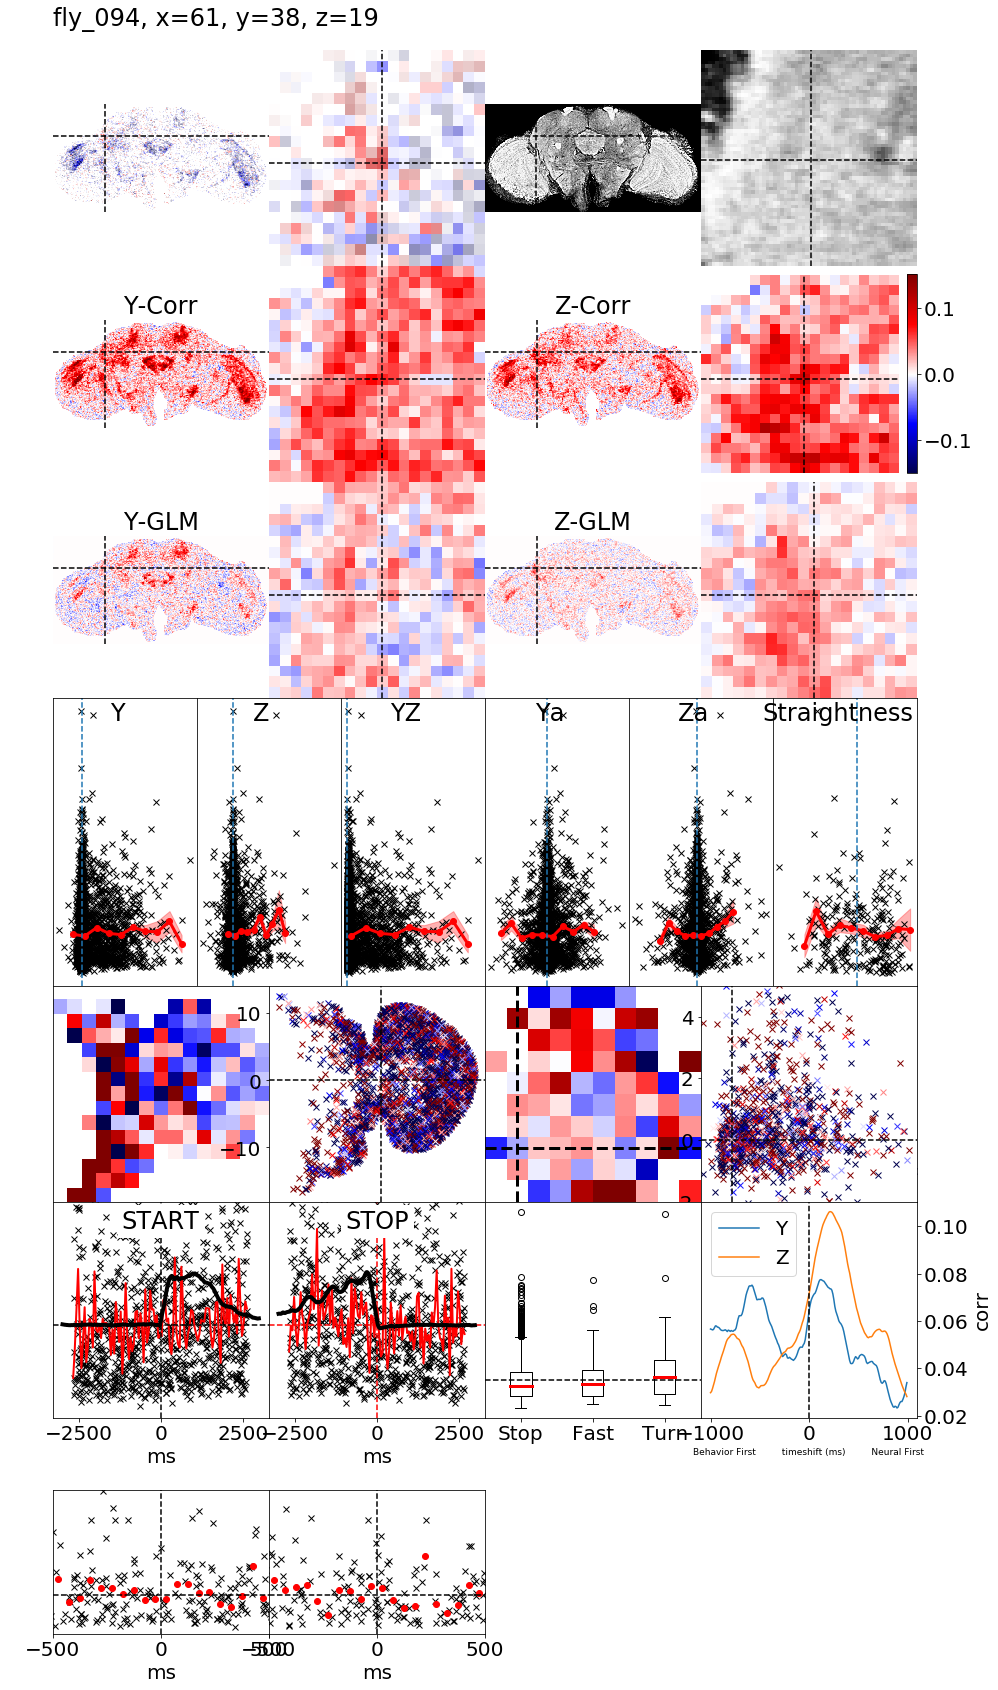

In [86]:
fig = plt.figure(figsize=(10,10))
fast = False
plt.suptitle('{}, x={}, y={}, z={}'.format(fly,x,y,z),x=0,y=2.36,ha='left')

############################
### 1D correlation plots ###
############################
for i, behavior_key in enumerate(['Y', 'Z', 'YZ', 'Ya', 'Za', 'Straightness']):
    ### Define neural data and behavior
    behavior = fictrac[behavior_key]

    ### Define Bins
    if behavior_key in ['Y', 'Z']:
        num_bins = 10
        min_bin = -1
        max_bin = 7
        neural_data_ = neural_data
    elif behavior_key in ['Ya', 'Za']:
        num_bins = 10
        min_bin = -5
        max_bin = 5
        neural_data_ = neural_data
    elif behavior_key == 'Straightness':
        num_bins = 10
        min_bin = -7
        max_bin = 7
        neural_data_ = neural_data[include_times]

    binned = scipy.stats.binned_statistic(x=behavior, values=neural_data_, statistic='mean', bins=num_bins, range=(min_bin,max_bin))
    binned_std = scipy.stats.binned_statistic(x=behavior, values=neural_data_, statistic='std', bins=num_bins, range=(min_bin,max_bin))
    binned_cnt = scipy.stats.binned_statistic(x=behavior, values=neural_data_, statistic='count', bins=num_bins, range=(min_bin,max_bin))
    centers = (binned.bin_edges[:-1] + binned.bin_edges[1:]) / 2
    binned_SE = binned_std.statistic/np.sqrt(binned_cnt.statistic)

    #ax = fig.add_subplot(3,5,i+1)
    ax = fig.add_axes([0+i*.2,1,.2,.4])
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.plot(behavior,neural_data_,'x',color='k')
    ax.plot(centers,binned.statistic,color='red',linewidth=3,marker='o')
    ax.fill_between(centers, binned.statistic-binned_SE, binned.statistic+binned_SE,alpha=.3,color='red')
    # plt.ylabel('FB voxel activity')
    ax.set_xlabel(behavior_key)
    # plt.title('FB single voxel')
    ax.axvline(0,linestyle='--')
    ax.set_title(x=.45,y=1-.1,label=behavior_key)
plt.subplots_adjust(wspace=0, hspace=0)

#################
### UMAP Hist ###
#################
ax = fig.add_axes([0,.7,.3,.3])
ax.imshow(umap_2d,cmap='seismic',vmin=-.5,vmax=.5)
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

##########################
### UMAP Hist - points ###
##########################
if not fast:
    ax = fig.add_axes([.3,.7,.3,.3])
    norm = mpl.colors.Normalize(vmin=-.5, vmax=.5)
    cmap = cm.seismic
    xss = cm.ScalarMappable(norm=norm, cmap=cmap)
    for i in range(3384):
        ax.plot(umap_x[i],umap_y[i],color=xss.to_rgba(neural_data[i]),marker='x',linestyle='-')
    ax.axvline(0, linestyle='--', color='k')
    ax.axhline(0, linestyle='--', color='k')

#################
### Fictrac2D ###
#################
ax = fig.add_axes([.6,.7,.3,.3])
ax.imshow(fictrac_2d,cmap='seismic',vmin=-1,vmax=1)
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)
ax.axhline(7,linestyle='--',color='k',linewidth=3)
ax.axvline(1,linestyle='--',color='k',linewidth=3)

##########################
### Fictrac2D - points ###
##########################
if not fast:
    ax = fig.add_axes([.9,.7,.3,.3])
    norm = mpl.colors.Normalize(vmin=-.5, vmax=.5)
    cmap = cm.seismic
    xss = cm.ScalarMappable(norm=norm, cmap=cmap)
    for i in range(3384):
        ax.plot(fictrac['Y'][i],fictrac['Z'][i],color=xss.to_rgba(neural_data[i]),marker='x',linestyle='-')
    ax.axvline(0, linestyle='--', color='k')
    ax.axhline(0, linestyle='--', color='k')
    plt.xlim(-1,6)
    plt.ylim(-2,5)

###########################
### Brain voxel map GLM ###
###########################
width = 10
vmin = -0.0002
vmax = 0.0002

ax = fig.add_axes([0,1.4,.3,.3])
plt.axis('off')
plt.imshow(Y_map[:,:,z].T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.axhline(y,color='k',linestyle='--')
plt.axvline(x,color='k',linestyle='--')
plt.title('Y-GLM')
ax = fig.add_axes([.3,1.4,.3,.3])
plt.axis('off')
plt.imshow(Y_map[x-width:x+width,y-width:y+width,z].T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.axhline(width,color='k',linestyle='--')
plt.axvline(width,color='k',linestyle='--')
ax = fig.add_axes([.6,1.4,.3,.3])
plt.axis('off')
plt.title('Z-GLM')
plt.imshow(Z_map[:,:,z].T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.axhline(y,color='k',linestyle='--')
plt.axvline(x,color='k',linestyle='--')
ax = fig.add_axes([.9,1.4,.3,.3])
plt.axis('off')
plt.imshow(Z_map[x-width:x+width,y-width:y+width,z].T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.axhline(width,color='k',linestyle='--')
plt.axvline(width,color='k',linestyle='--')
plt.subplots_adjust(wspace=0, hspace=0)

############################
### Brain voxel map corr ###
###########################3
width = 10
vmin = -0.15
vmax = 0.15

ax = fig.add_axes([0,1.7,.3,.3])
plt.axis('off')
plt.imshow(Y_corr_map[:,:,z].T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.axhline(y,color='k',linestyle='--')
plt.axvline(x,color='k',linestyle='--')
plt.title('Y-Corr')
ax = fig.add_axes([.3,1.7,.3,.3])
plt.axis('off')
plt.imshow(Y_corr_map[x-width:x+width,y-width:y+width,z].T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.axhline(width,color='k',linestyle='--')
plt.axvline(width,color='k',linestyle='--')
ax = fig.add_axes([.6,1.7,.3,.3])
plt.axis('off')
plt.title('Z-Corr')
plt.imshow(Z_corr_map[:,:,z].T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.axhline(y,color='k',linestyle='--')
plt.axvline(x,color='k',linestyle='--')
ax = fig.add_axes([.9,1.7,.3,.3])
plt.axis('off')
plt.imshow(Z_corr_map[x-width:x+width,y-width:y+width,z].T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.axhline(width,color='k',linestyle='--')
plt.axvline(width,color='k',linestyle='--')
plt.subplots_adjust(wspace=0, hspace=0)
plt.colorbar(fraction=0.046, pad=0.04)
#ax = fig.add_axes([1.2,1.7,.3,.3])
#fig.colorbar(for_colorbar, ax=ax)

###############
### Anatomy ###
###############
width = 30
ax = fig.add_axes([.6,2,.3,.3])
X_anat = int(x/Y_map.shape[0]*anatomy.shape[0])
Y_anat = int(y/Y_map.shape[1]*anatomy.shape[1])
Z_anat = int(z/Y_map.shape[2]*anatomy.shape[2])
plt.axis('off')
plt.imshow(anatomy[:,:,Z_anat].T, cmap='gray')
plt.axhline(Y_anat,color='k',linestyle='--')
plt.axvline(X_anat,color='k',linestyle='--')
ax = fig.add_axes([.9,2,.3,.3])
plt.axis('off')
plt.imshow(anatomy[X_anat-width:X_anat+width,Y_anat-width:Y_anat+width,Z_anat].T, cmap='gray')
plt.axhline(width,color='k',linestyle='--')
plt.axvline(width,color='k',linestyle='--')


#####################
### Start Trigger ###
#####################
ax = fig.add_axes([0,.4,.3,.3])
before = 3000 #in ms
after = 3000 # in ms
jump = timestamps[1,0]-timestamps[0,0]
num_neural_points = int(before/jump)

before = int(before/10) # now everything is in units of 10ms
after = int(after/10)
bins = bbb.create_bins(10,before*10,after*10)[:-1]

xss = []; yss = []
for i in range(len(start_bouts)):
    nearest = np.searchsorted(timestamps[:,z]/10, start_bouts[i]['start'])
    offset = (timestamps[nearest,z]/10 - start_bouts[i]['start'])*10
    xs = np.arange(offset-num_neural_points*jump,offset+num_neural_points*jump,jump)
    ys = neural_data[nearest-num_neural_points:nearest+num_neural_points]
    plt.plot(xs,ys,marker='x',linestyle='',color='k') # for plotting individual neural points
    xss.append(xs); yss.append(ys)
xss = np.asarray(xss); yss = np.asarray(yss)

neural_bin_size = 50
neural_bins = np.arange(-before*10,after*10,neural_bin_size)
bin_id = np.digitize(xss.ravel(), neural_bins)
avgs = []
for i in range(len(neural_bins)):
    avgs.append(np.mean(yss.ravel()[np.where(bin_id==i)[0]]))
plt.plot(neural_bins-0.5*neural_bin_size,avgs,linewidth=2,color='red')

plt.axvline(0,linestyle='--',color='k')
plt.xlabel('ms')
ax.yaxis.set_visible(False)
plt.axhline(0,linestyle='--',color='k')
plt.ylim(-1.5,2)
#plt.xlim(-1000,1000)
plt.title('START',y=.85,backgroundcolor='white')

# Plot behavior
all_bouts = [fictrac['Yh'][bout['start']-before:bout['start']+after] for bout in start_bouts][1:-1]
all_bouts = np.asarray(all_bouts)
avg_bout = np.mean(all_bouts,axis=0)
plt.plot(bins,avg_bout/3,color='k',linewidth=4)

### zooom-in ###
ax = fig.add_axes([0,.1,.3,.2])
plt.plot(xss,yss,marker='x',linestyle='',color='k') # for plotting individual neural points
plt.plot(neural_bins-0.5*neural_bin_size,avgs,linewidth=2,color='red',linestyle='',marker='o')
plt.axvline(0,linestyle='--',color='k')
plt.xlabel('ms')
ax.yaxis.set_visible(False)
plt.axhline(0,linestyle='--',color='k')
plt.ylim(-1.5,4)
plt.xlim(-500,500)

####################
### Stop Trigger ###
####################
ax = fig.add_axes([.3,.4,.3,.3])
before = 3000 #in ms
after = 3000 # in ms
num_neural_points = int(before/jump)

before = int(before/10) # now everything is in units of 10ms
after = int(after/10)
bins = bbb.create_bins(10,before*10,after*10)[:-1]

xss = []; yss = []
for i in range(len(stop_bouts)):
    nearest = np.searchsorted(timestamps[:,z]/10, stop_bouts[i]['end'])
    offset = (timestamps[nearest,z]/10 - stop_bouts[i]['end'])*10
    jump = timestamps[1,0]-timestamps[0,0]
    xs = np.arange(offset-num_neural_points*jump,offset+num_neural_points*jump,jump)
    ys = neural_data[nearest-num_neural_points:nearest+num_neural_points]
    plt.plot(xs,ys,marker='x',linestyle='',color='k') # for plotting individual neural points
    xss.append(xs); yss.append(ys)
xss = np.asarray(xss); yss = np.asarray(yss)

neural_bins = np.arange(-before*10,after*10,neural_bin_size)
bin_id = np.digitize(xss.ravel(), neural_bins)
avgs = []
for i in range(len(neural_bins)):
    avgs.append(np.mean(yss.ravel()[np.where(bin_id==i)[0]]))
    
plt.plot(neural_bins-0.5*neural_bin_size,avgs,linewidth=2,color='red')
plt.axvline(0,linestyle='--',color='r')
plt.axhline(0,linestyle='--',color='r')
plt.xlabel('ms')
ax.yaxis.set_visible(False)
plt.title('STOP',y=.85,backgroundcolor='white')
plt.ylim(-1.5,2)

all_bouts = [fictrac['Yh'][bout['end']-before:bout['end']+after] for bout in stop_bouts][1:-1]
all_bouts = np.asarray(all_bouts)
avg_bout = np.mean(all_bouts,axis=0)
plt.plot(bins,avg_bout/3,color='k',linewidth=4)

### zooom-in ###
ax = fig.add_axes([.3,.1,.3,.2])
plt.plot(xss,yss,marker='x',linestyle='',color='k') # for plotting individual neural points
plt.plot(neural_bins-0.5*neural_bin_size,avgs,linewidth=2,color='red',linestyle='',marker='o')
plt.axvline(0,linestyle='--',color='k')
plt.xlabel('ms')
ax.yaxis.set_visible(False)
plt.axhline(0,linestyle='--',color='k')
plt.ylim(-1.5,4)
plt.xlim(-500,500)

######################
### State-box-plot ###
######################
ax = fig.add_axes([.6,.4,.3,.3])
data_for_boxplot = [neural_data[stop_times], neural_data[forward_times],  neural_data[rotation_pos_times]]
bp = ax.boxplot(data_for_boxplot);
for median in bp['medians']: 
    median.set(color ='red', 
               linewidth = 3)
ax.set_xticklabels(['Stop', 'Fast', 'Turn']);
ax.yaxis.set_visible(False)
ax.axhline(0,color='k',linestyle='--')

##################
### Cross-Corr ###
##################
ax = fig.add_axes([.9,.4,.3,.3])
plt.plot(cross_corr_shifts, cross_corr['Yi'], label='Y')
plt.plot(cross_corr_shifts, cross_corr['Zi'], label='Z')
plt.axvline(0,color='k',linestyle='--')
plt.ylabel('corr')
plt.xlabel('Behavior First         timeshift (ms)         Neural First',fontsize=9)
plt.legend()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
#ax.set_title(x=.45,y=1-.1,label='Y')
#plt.title('FB voxel with rot V')
#plt.text(x=-400,y=0.04,s='Behavior\nFirst')

######################
### Cross-Corr MAP ###
######################
width = 10
ax = fig.add_axes([0,2,.3,.3])
alphas = Normalize(.02, .15, clip=True)(np.abs(lag_corr_values_[z,:,:]))
alphas = np.clip(alphas, 0, 1)
colors = Normalize(-300, 300)(lag_time_peak_[z,:,:])
cmap = plt.cm.seismic
colors = cmap(colors)
colors[..., -1] = alphas
to_plot = np.swapaxes(colors,0,1)
plt.imshow(to_plot)
plt.axis('off')
plt.axhline(y,color='k',linestyle='--')
plt.axvline(x,color='k',linestyle='--')
#zoom
ax = fig.add_axes([.3,2,.3,.3])
plt.axis('off')
plt.imshow(to_plot[y-width:y+width,x-width:x+width])
plt.axhline(width,color='k',linestyle='--')
plt.axvline(width,color='k',linestyle='--')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr)
plt.savefig(fname,dpi=300,bbox_inches='tight')

# Work space

In [467]:
brain.shape

(256, 128, 49, 3384)

In [96]:
timepoint_shifts = list(range(-1000,1000,50)) # in ms

fictrac_shifts = []
for shift in timepoint_shifts:
    fictrac_interp = np.nan_to_num(fictrac['Zi'](timestamps[:,23]+shift), copy=False);
    fictrac_shifts.append(scipy.stats.pearsonr(fictrac_interp, np.nan_to_num(fictrac['Yi'](timestamps[:,23]),copy=False))[0])

Text(0.5, 0, 'Rotation First         timeshift (ms)         Forward First')

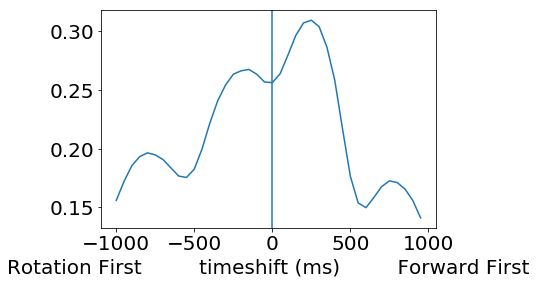

In [101]:
plt.plot(timepoint_shifts, fictrac_shifts)
plt.axvline(0)
plt.xlabel('Rotation First         timeshift (ms)         Forward First',fontsize=20)

#a positive value to the right means that a turn to-come is correlated with the fly moving forward

In [ ]:
####

In [140]:
timepoint_shifts = list(range(-5000,5000,100)) # in ms

fictrac_shifts = []
for shift in timepoint_shifts:
    fictrac_interp = np.nan_to_num(np.abs(fictrac['Zi'](high_res_timepoints+shift)), copy=False);
    fictrac_shifts.append(scipy.stats.pearsonr(fictrac_interp, np.nan_to_num(np.abs(fictrac['Zi'](high_res_timepoints)),copy=False))[0])

Text(0.5, 1.0, 'Z cross corr')

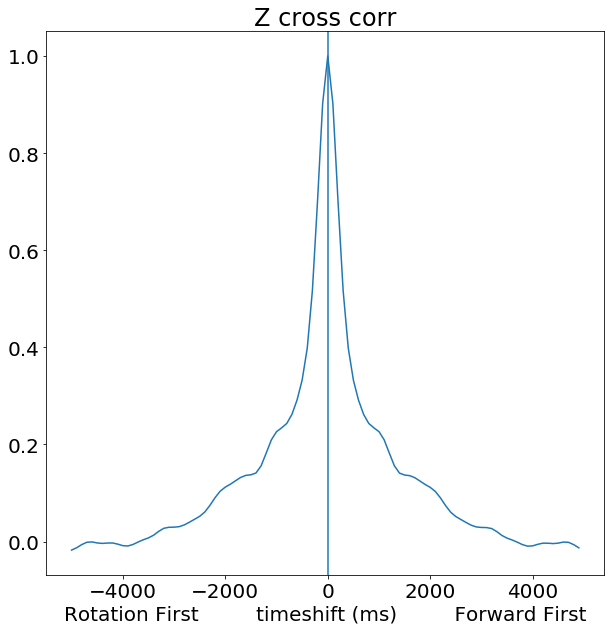

In [142]:
plt.figure(figsize=(10,10))
plt.plot(timepoint_shifts, fictrac_shifts)
plt.axvline(0)
plt.xlabel('Rotation First         timeshift (ms)         Forward First',fontsize=20)
plt.title('Z cross corr')
#a positive value to the right means that a turn to-come is correlated with the fly moving forward

In [ ]:
###

In [124]:
timepoint_shifts = list(range(-1000,1000,50)) # in ms

fictrac_shifts = []
for shift in timepoint_shifts:
    fictrac_interp = np.nan_to_num(fictrac['Yi'](high_res_timepoints+shift), copy=False);
    fictrac_shifts.append(scipy.stats.pearsonr(fictrac_interp, np.nan_to_num(np.abs(fictrac['Zi'](high_res_timepoints)),copy=False))[0])

Text(0.5, 0, 'Forward First         timeshift (ms)         Rotation First')

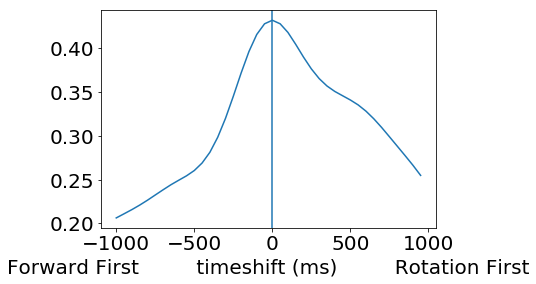

In [125]:
plt.plot(timepoint_shifts, fictrac_shifts)
plt.axvline(0)
plt.xlabel('Forward First         timeshift (ms)         Rotation First',fontsize=20)

#a positive value to the right means that forward motion to-come is correlated with the fly turning
# try with 

In [ ]:
####

In [117]:
timepoint_shifts = list(range(-1000,1000,50)) # in ms

fictrac_shifts = []
for shift in timepoint_shifts:
    fictrac_interp = np.nan_to_num(np.abs(fictrac['Zi'](timestamps[:,23]+shift)), copy=False);
    fictrac_shifts.append(scipy.stats.pearsonr(fictrac_interp, np.nan_to_num(fictrac['Yi'](timestamps[:,23]),copy=False))[0])

Text(0.5, 0, 'Rotation First         timeshift (ms)         Forward First')

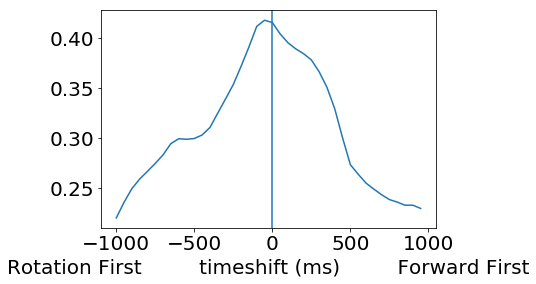

In [118]:
plt.plot(timepoint_shifts, fictrac_shifts)
plt.axvline(0)
plt.xlabel('Rotation First         timeshift (ms)         Forward First',fontsize=20)

#a positive value to the right means that a turn to-come is correlated with the fly moving forward

In [119]:
timepoint_shifts = list(range(-1000,1000,50)) # in ms

fictrac_shifts = []
for shift in timepoint_shifts:
    fictrac_interp = np.nan_to_num(fictrac['Yi'](timestamps[:,23]+shift), copy=False);
    fictrac_shifts.append(scipy.stats.pearsonr(fictrac_interp, np.nan_to_num(np.abs(fictrac['Zi'](timestamps[:,23])),copy=False))[0])

Text(0.5, 0, 'Forward First         timeshift (ms)         Rotation First')

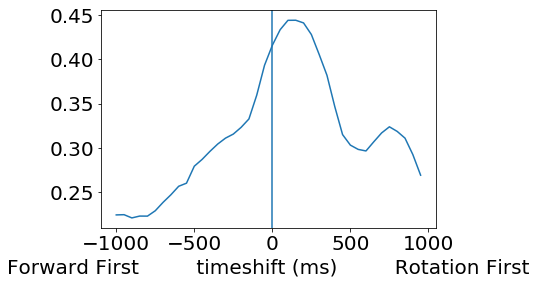

In [120]:
plt.plot(timepoint_shifts, fictrac_shifts)
plt.axvline(0)
plt.xlabel('Forward First         timeshift (ms)         Rotation First',fontsize=20)

#a positive value to the right means that forward motion to-come is correlated with the fly turning
# try with 

In [106]:
timepoint_shifts = list(range(-1000,1000,50)) # in ms

fictrac_shifts = []
for shift in timepoint_shifts:
    fictrac_interp = np.nan_to_num(np.abs(fictrac['Yi'](timestamps[:,23]+shift)), copy=False);
    fictrac_shifts.append(scipy.stats.pearsonr(fictrac_interp, np.nan_to_num(np.abs(fictrac['Zi'](timestamps[:,23])),copy=False))[0])

Text(0.5, 0, 'Forward First         timeshift (ms)         Rotation First')

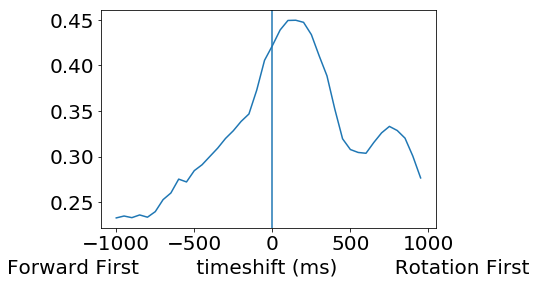

In [107]:
plt.plot(timepoint_shifts, fictrac_shifts)
plt.axvline(0)
plt.xlabel('Forward First         timeshift (ms)         Rotation First',fontsize=20)

#a positive value to the right means that forward motion to-come is correlated with the fly turning
# try with 

In [501]:
### Prep data for cross corr peaks
z=24
brain_flat = brain[:,:,z,:].reshape(-1,3384)
fictrac = interp_fictrac(z=z)

In [ ]:
1

In [ ]:
timepoint_shifts = list(range(-300,300,30)) # in ms

lag_time_peak_all = []
lag_corr_values_all = []
for z in range(49):
    print("***{}***".format(z))
    brain_flat = brain[:,:,z,:].reshape(-1,3384)
    fictrac = interp_fictrac(z=z)

    lag_time_peak = []
    lag_corr_values = []
    for i in range(32768):
        if i%1000==0:
            print(i)
        fictrac_shifts = []
        for shift in timepoint_shifts:
            fictrac_interp = np.nan_to_num(fictrac['Zi'](timestamps[:,z]+shift), copy=False);
            fictrac_shifts.append(scipy.stats.pearsonr(fictrac_interp, brain_flat[i,:])[0])
        lag_time_peak.append(timepoint_shifts[np.argmax(fictrac_shifts)])
        lag_corr_values.append(np.max(fictrac_shifts))
    lag_time_peak_all.append(lag_time_peak)
    lag_corr_values_all.append(lag_corr_values)

***0***
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
***1***
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
***2***
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
***3***
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
***4***
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
***5***
0
1000
2000
3000
4000
5000


In [ ]:
save_file = os.path.join(dataset_path,fly,'func_0','20201104_cross_corr_times.npy')
np.save(save_file, np.asarray(lag_time_peak_all))

save_file = os.path.join(dataset_path,fly,'func_0','20201104_cross_corr_values.npy')
np.save(save_file, np.asarray(lag_corr_values_all))

In [5]:
load_file = os.path.join(dataset_path,fly,'func_0','20201104_cross_corr_times.npy')
lag_time_peak_all = np.load(load_file)

load_file = os.path.join(dataset_path,fly,'func_0','20201104_cross_corr_values.npy')
lag_corr_values_all = np.load(load_file)

lag_time_peak_ = np.reshape(lag_time_peak_all, (49, 256,128))
lag_corr_values_ = np.reshape(lag_corr_values_all, (49, 256,128))

In [6]:
lag_time_peak_all.shape

(49, 32768)

In [7]:
lag_corr_values_all.shape

(49, 32768)

In [503]:
lag_time_peak_ = np.reshape(lag_time_peak, (256,128))
lag_corr_values_ = np.reshape(lag_corr_values, (256,128))

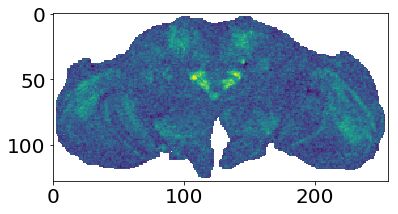

In [496]:
plt.imshow(Y_corr_map[:,:,22].T)

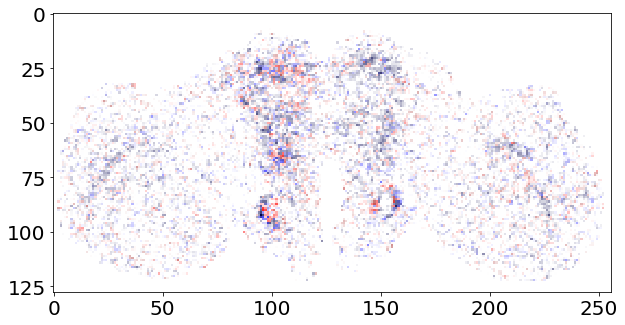

In [30]:
z=32
plt.figure(figsize=(10,10))
alphas = Normalize(.02, .15, clip=True)(np.abs(lag_corr_values_[z,:,:]))
alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
# Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
colors = Normalize(-300, 300)(lag_time_peak_[z,:,:])
cmap = plt.cm.seismic
colors = cmap(colors)
# Now set the alpha channel to the one we created above
colors[..., -1] = alphas
to_plot = np.swapaxes(colors,0,1)
plt.imshow(to_plot)
#plt.colorbar(cmap)
#plt.axvline(117,linestyle='--',color='k')
#plt.axhline(50,linestyle='--',color='k')

#plt.xlim(100,150)
#plt.ylim(40,60)

In [22]:
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20201105_cross_corr_movie'
os.mkdir(save_path)

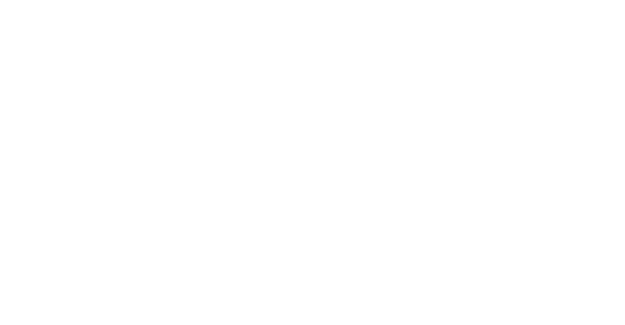

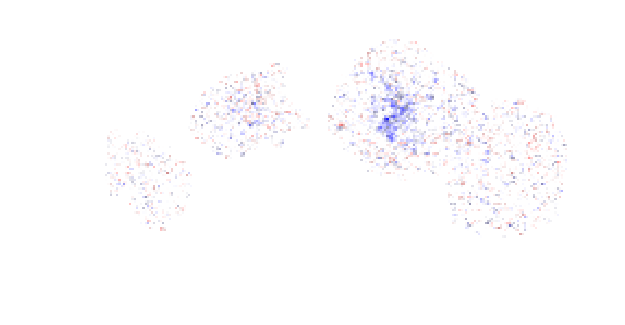

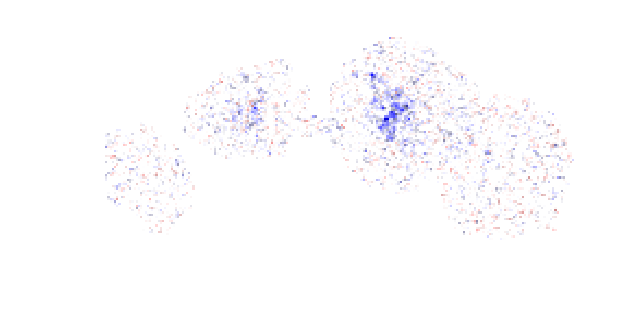

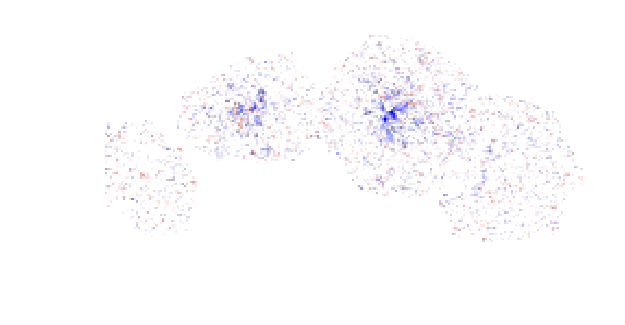

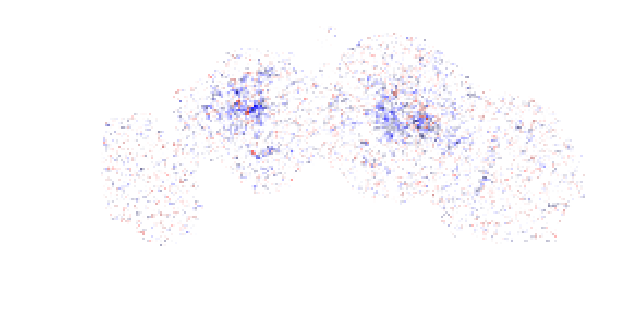

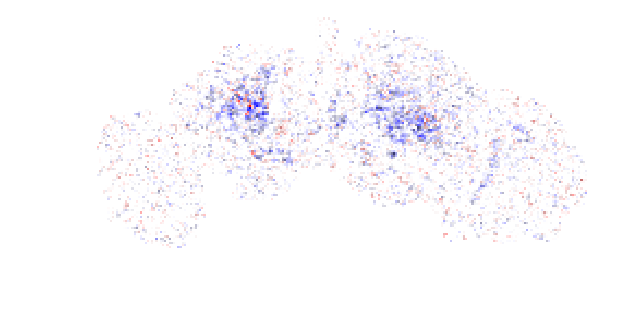

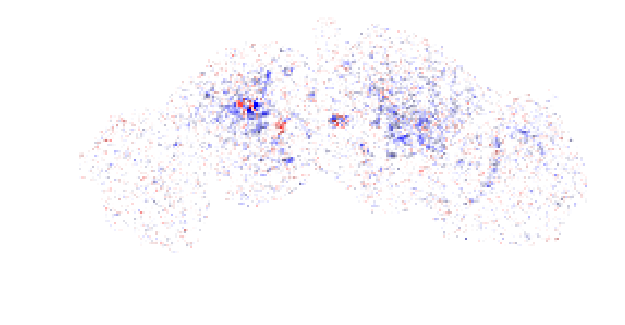

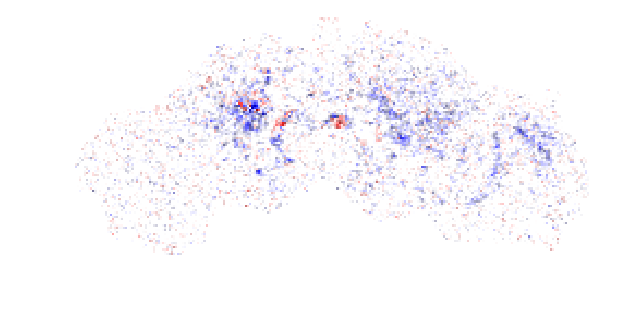

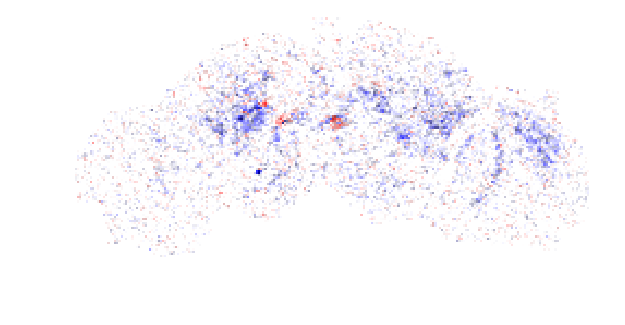

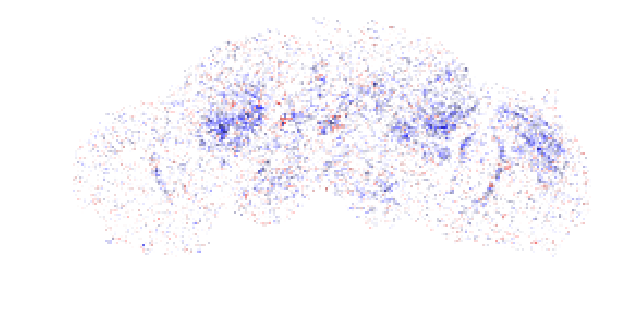

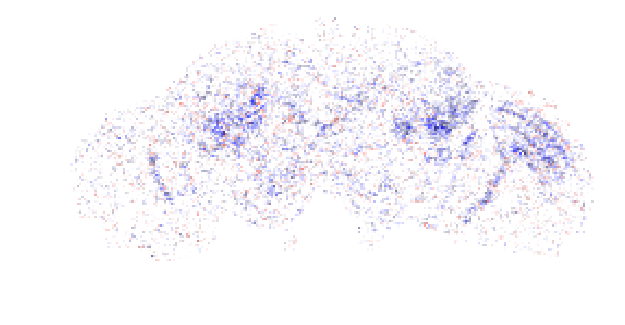

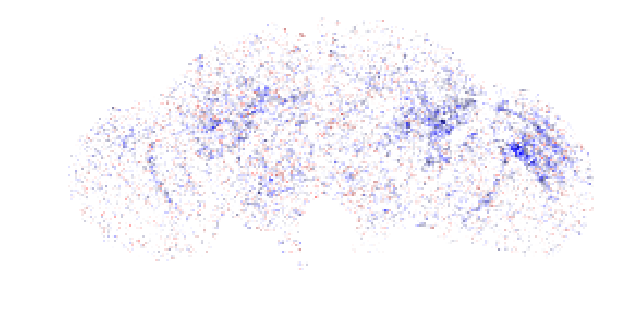

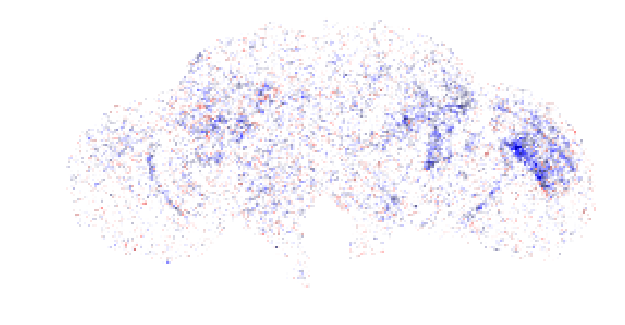

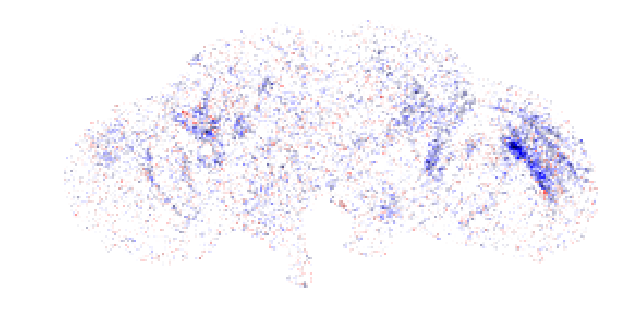

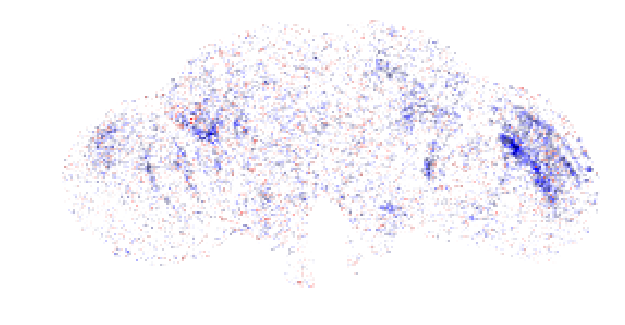

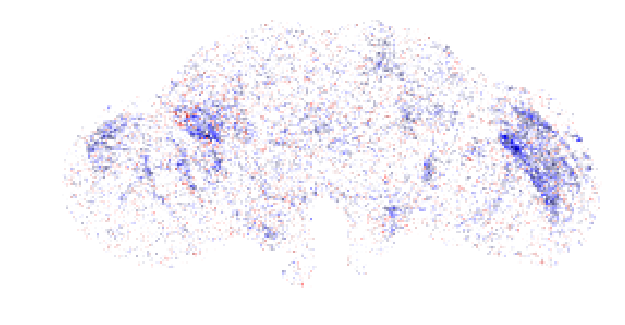

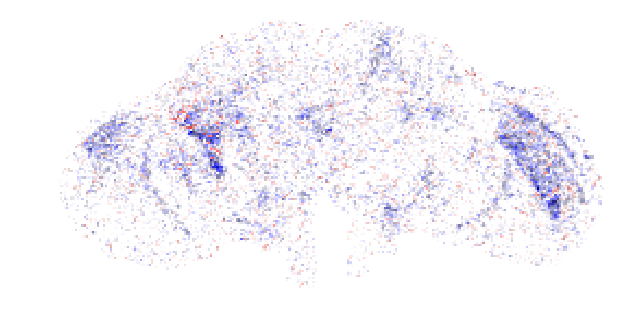

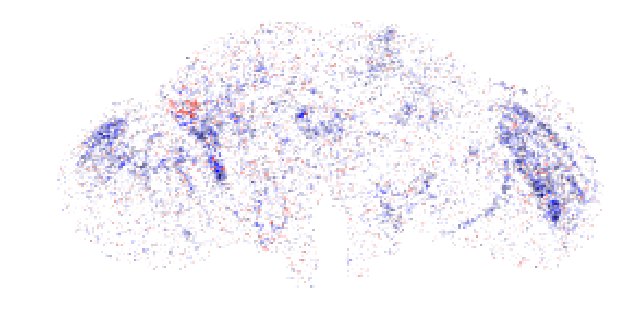

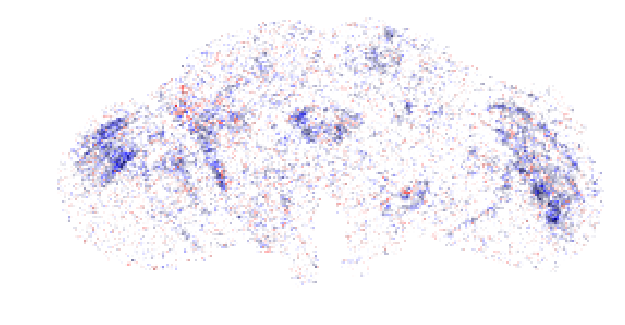

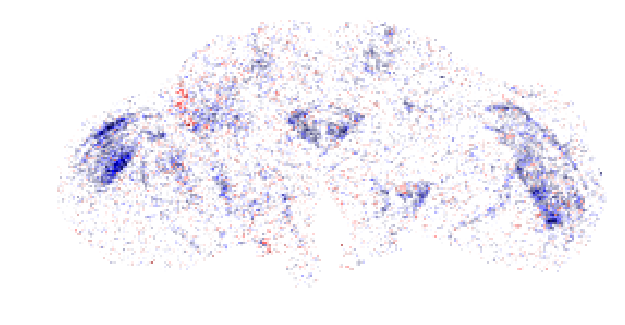

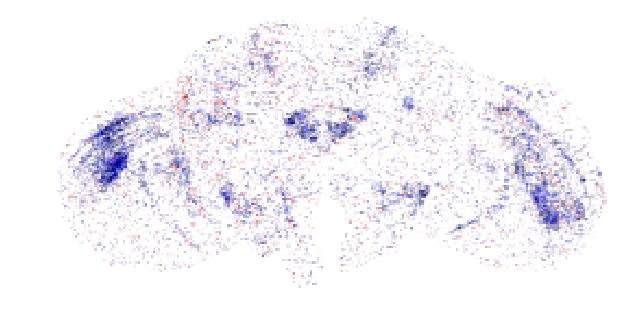

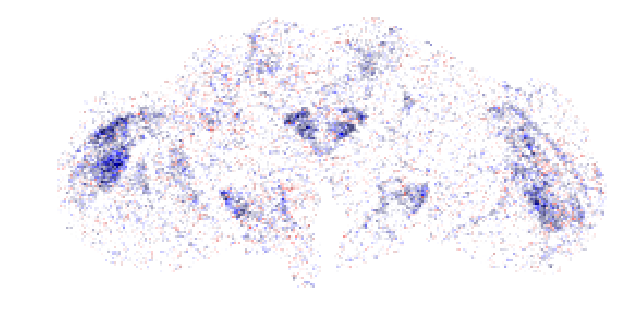

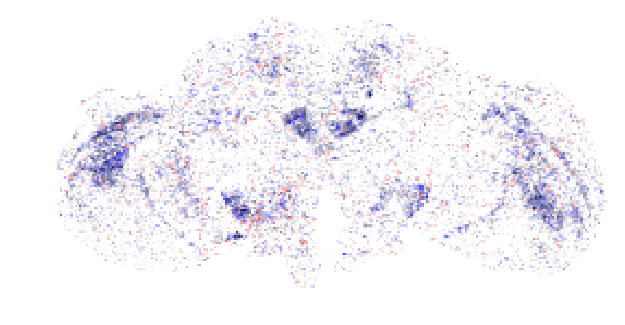

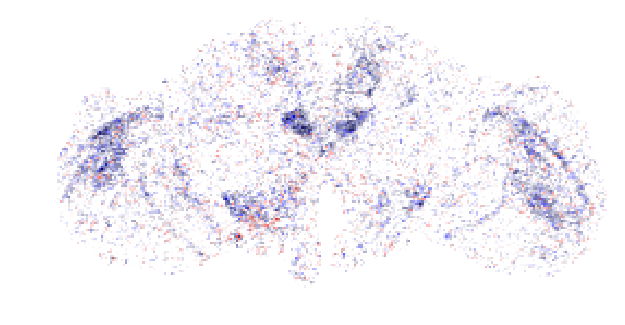

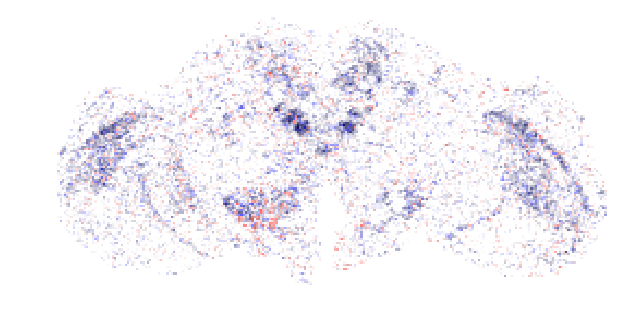

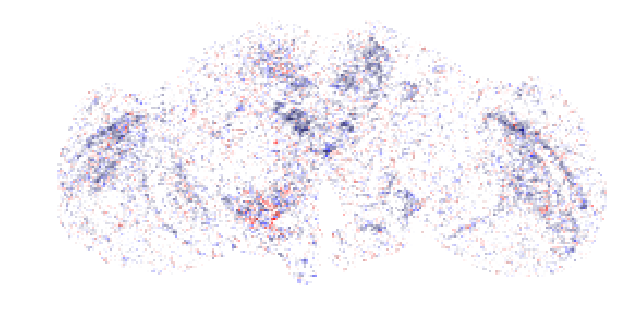

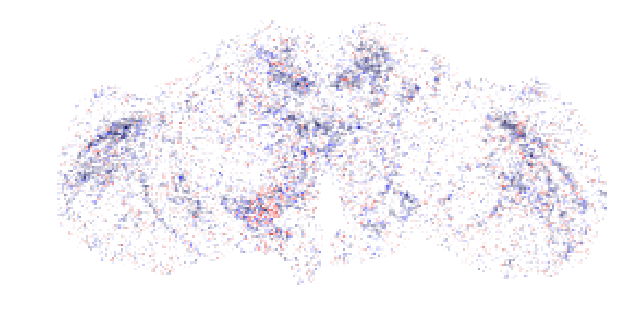

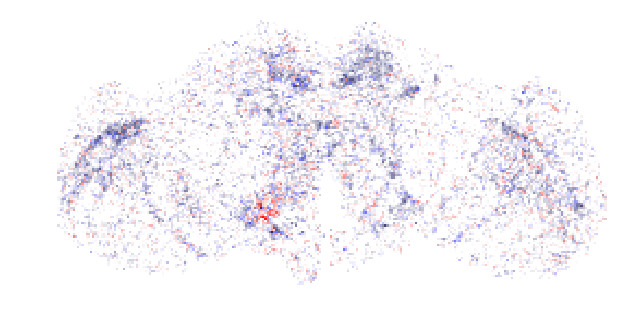

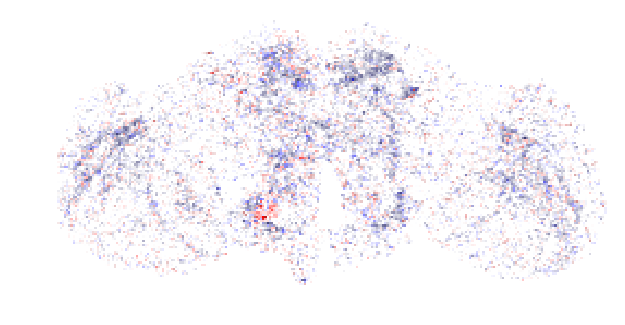

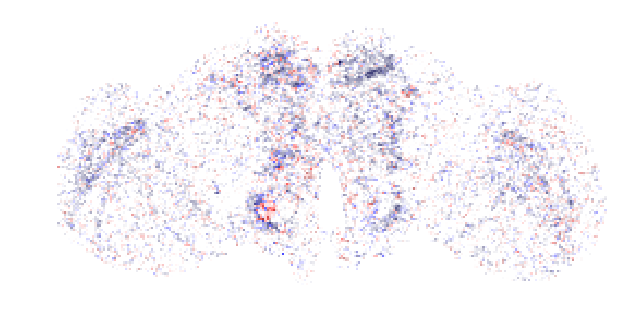

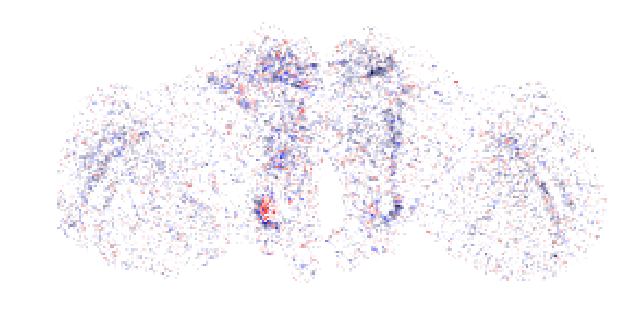

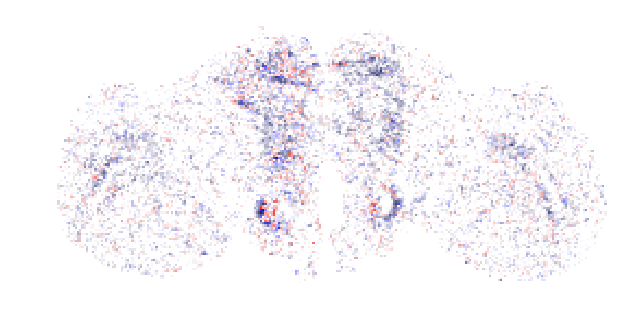

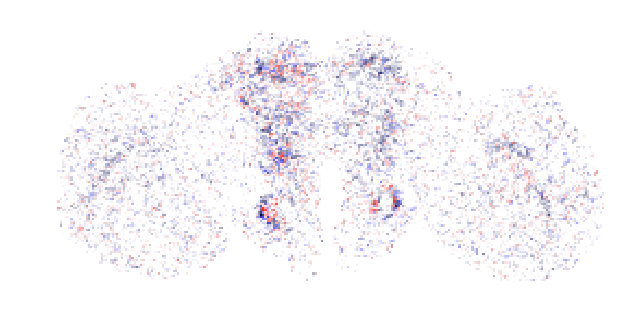

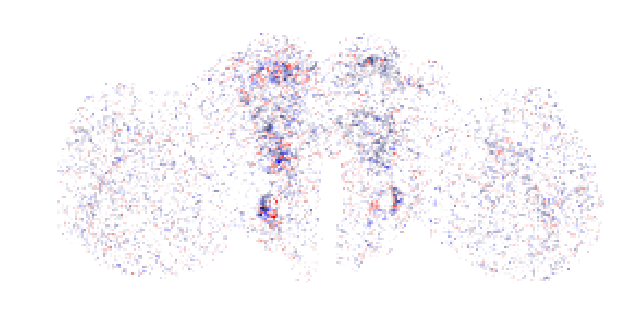

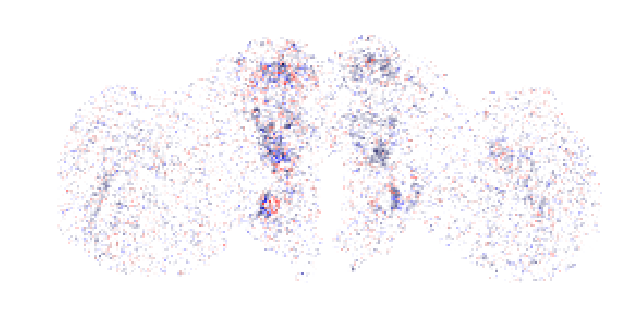

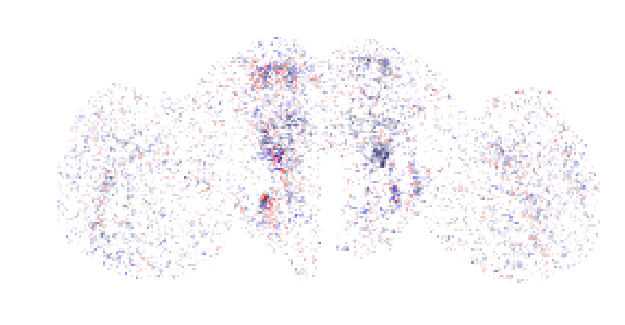

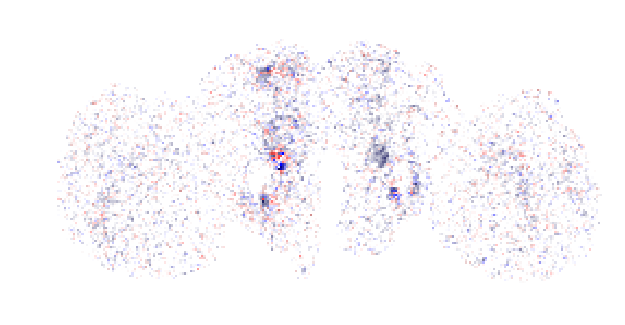

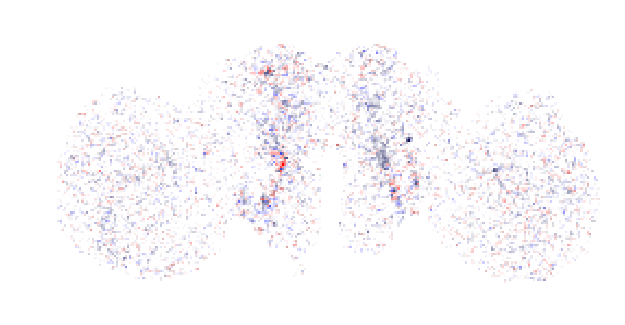

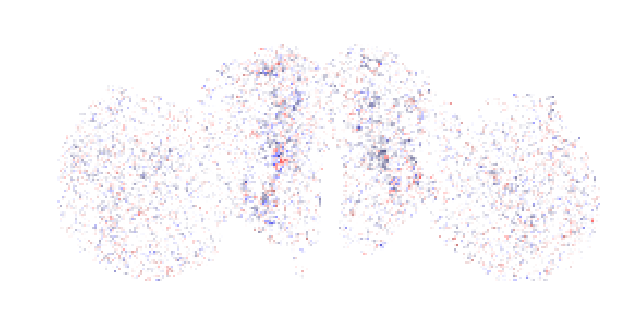

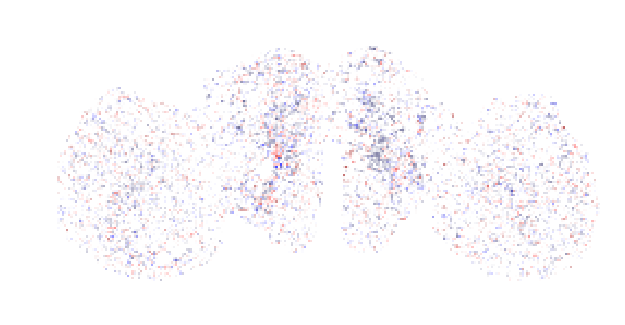

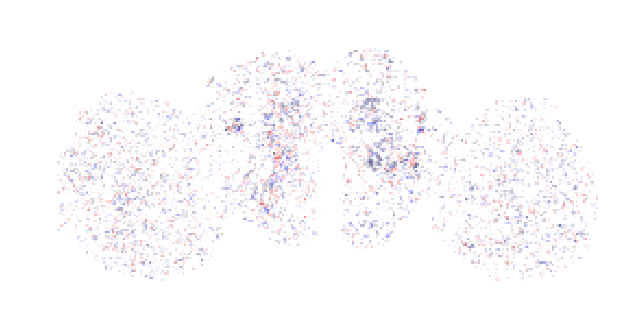

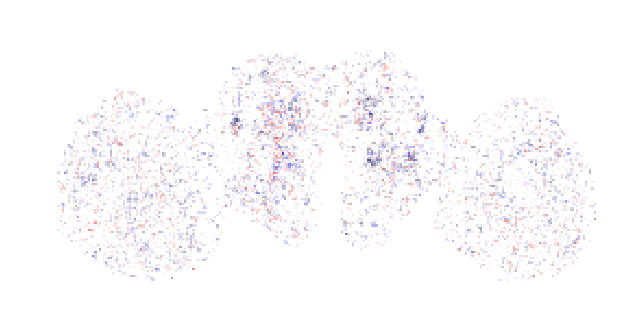

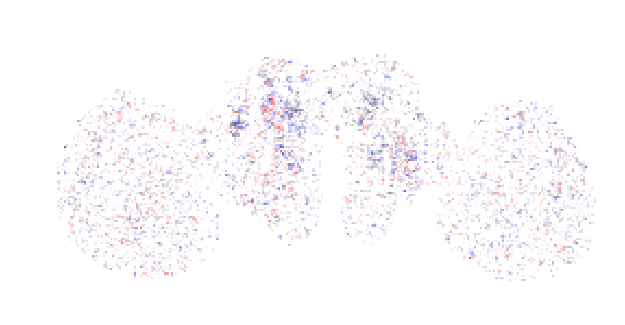

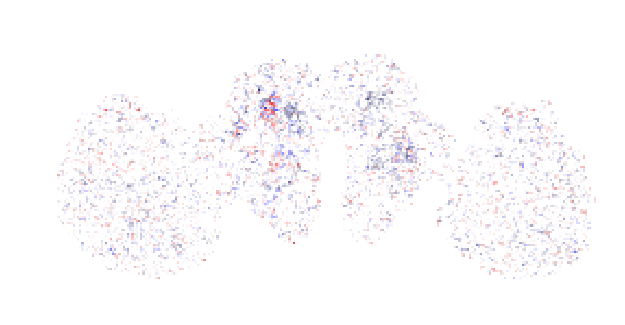

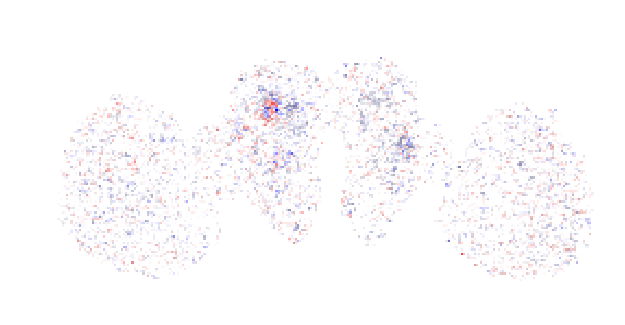

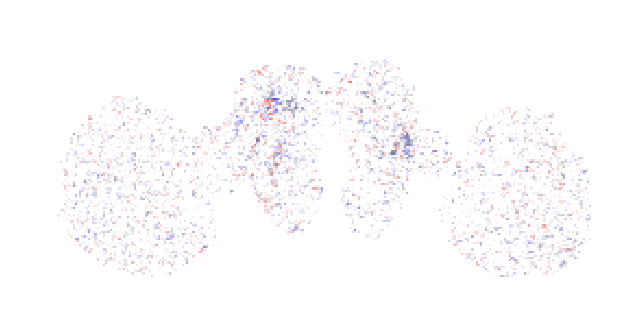

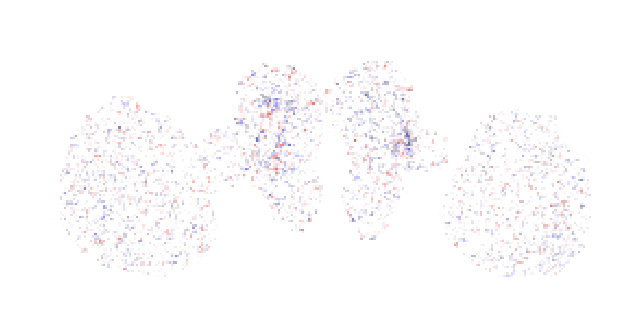

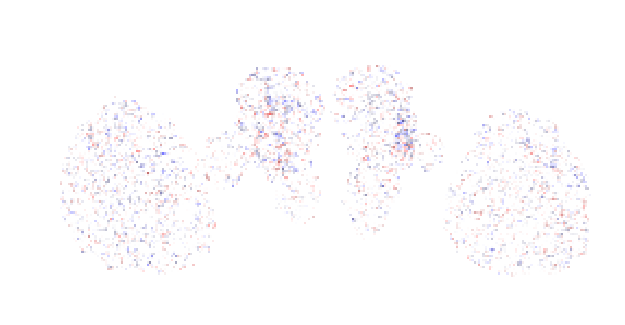

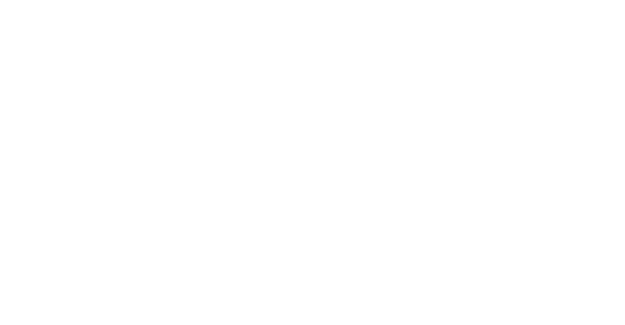

In [35]:
#grid = ImageGrid(fig, 111, nrows_ncols=(7, 7), axes_pad=.05)

for z in range(49):
    plt.figure(figsize=(10,10))

    alphas = Normalize(.02, .15, clip=True)(np.abs(lag_corr_values_[z,:,:]))
    alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
    # Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
    colors = Normalize(-300, 300)(lag_time_peak_[z,:,:])
    cmap = plt.cm.seismic
    colors = cmap(colors)
    # Now set the alpha channel to the one we created above
    colors[..., -1] = alphas
    to_plot = np.swapaxes(colors,0,1)
    plt.imshow(to_plot)
    #grid[z].imshow(to_plot)
    plt.axis('off')
    
    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20201105_cross_corr_movie'
    #timestr = time.strftime("%Y%m%d-%H%M%S")
    fname = os.path.join(save_path, str(z).zfill(2))
    plt.savefig(fname,dpi=300,bbox_inches='tight')

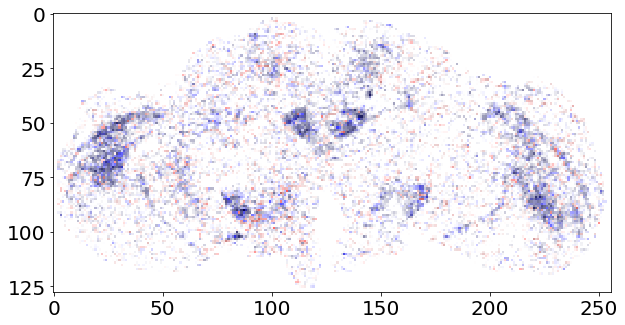

In [500]:
plt.figure(figsize=(10,10))
alphas = Normalize(.02, .15, clip=True)(np.abs(lag_corr_values_))
alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
# Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
colors = Normalize(-300, 300)(lag_time_peak_)
cmap = plt.cm.seismic
colors = cmap(colors)
# Now set the alpha channel to the one we created above
colors[..., -1] = alphas
to_plot = np.swapaxes(colors,0,1)
plt.imshow(to_plot)
#plt.colorbar(cmap)
#plt.axvline(117,linestyle='--',color='k')
#plt.axhline(50,linestyle='--',color='k')

#plt.xlim(100,150)
#plt.ylim(40,60)

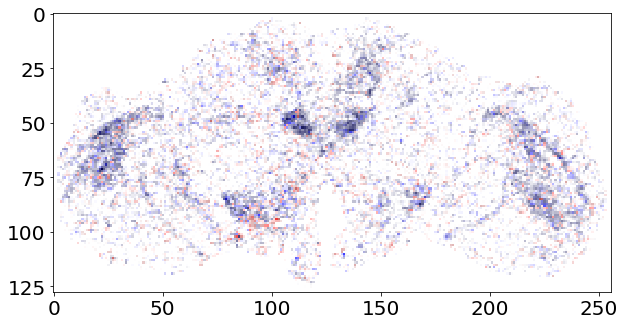

In [483]:
plt.figure(figsize=(10,10))
alphas = Normalize(.02, .15, clip=True)(np.abs(lag_corr_values_))
alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
# Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
colors = Normalize(-300, 300)(lag_time_peak_)
cmap = plt.cm.seismic
colors = cmap(colors)
# Now set the alpha channel to the one we created above
colors[..., -1] = alphas
to_plot = np.swapaxes(colors,0,1)
plt.imshow(to_plot)
#plt.colorbar(cmap)
#plt.axvline(117,linestyle='--',color='k')
#plt.axhline(50,linestyle='--',color='k')

#plt.xlim(100,150)
#plt.ylim(40,60)

In [462]:
ms_before_start = 500

offsets = []
good_points = []
bout_ids=[]
for i in range(len(start_bouts)):
    nearest = np.searchsorted(timestamps[:,z]/10, start_bouts[i]['start'])
    offset = (timestamps[nearest,z]/10 - start_bouts[i]['start'])*10
    offsets.append(offset)
    if offset < ms_before_start:
        
        good_points.append(nearest)
        bout_ids.append(i)

In [463]:
good_points

[94,
 148,
 207,
 226,
 254,
 291,
 307,
 321,
 390,
 482,
 523,
 582,
 591,
 604,
 619,
 661,
 674,
 708,
 727,
 745,
 783,
 813,
 845,
 877,
 896,
 925,
 936,
 984,
 1008,
 1067,
 1085,
 1104,
 1117,
 1143,
 1174,
 1216,
 1237,
 1272,
 1283,
 1297,
 1315,
 1354,
 1429,
 1450,
 1470,
 1512,
 1532,
 1553,
 1565,
 1596,
 1617,
 1633,
 1644,
 1661,
 1692,
 1728,
 1746,
 1890,
 1937,
 1956,
 2116,
 2142,
 2149,
 2174,
 2193,
 2220,
 2242,
 2272,
 2299,
 2341,
 2367,
 2376,
 2417,
 2463,
 2474,
 2501,
 2532,
 2592,
 2611,
 2670,
 2680,
 2715,
 2727,
 2769,
 2793,
 2836,
 2909,
 3009,
 3037,
 3122,
 3153,
 3199,
 3226,
 3371]

In [464]:
out = np.mean(brain[:,:,z,good_points], -1)

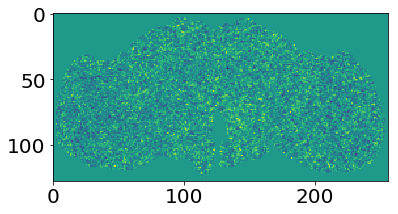

In [465]:
plt.imshow(out.T)

(37709.2281785, 39709.2281785)

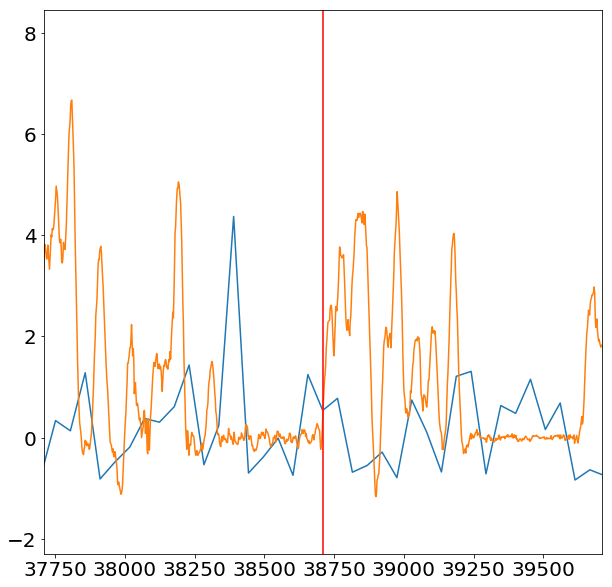

In [455]:
point = good_points[4]
plt.figure(figsize=(10,10))
plt.plot(timestamps[:,z]/10, brain[x,y,z,:])
plt.plot(fictrac['Yh'])
plt.axvline(timestamps[point,z]/10,color='r')
plt.axvline(start_bouts[0]['start'],color='k')

plt.xlim(timestamps[point,z]/10-1000,timestamps[point,z]/10+1000)

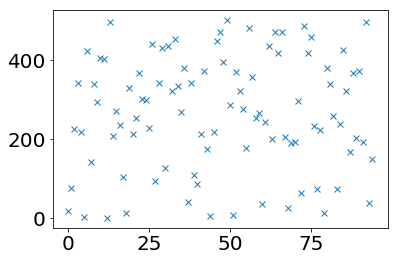

In [334]:
plt.plot(offsets,'x')

Text(0.5, 0.85, 'START')

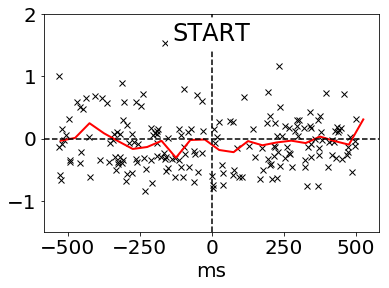

In [461]:
before = 600 #in ms
after = 600 # in ms
jump = timestamps[1,0]-timestamps[0,0]
num_neural_points = int(before/jump)

before = int(before/10) # now everything is in units of 10ms
after = int(after/10)
bins = bbb.create_bins(10,before*10,after*10)[:-1]

xss = []; yss = []
for i in range(len(start_bouts)):
    nearest = np.searchsorted(timestamps[:,z]/10, start_bouts[i]['start'])
    offset = (timestamps[nearest,z]/10 - start_bouts[i]['start'])*10
    xs = np.arange(offset-num_neural_points*jump,offset+num_neural_points*jump,jump)
    ys = neural_data[nearest-num_neural_points:nearest+num_neural_points]
    plt.plot(xs,ys,marker='x',linestyle='',color='k') # for plotting individual neural points
    xss.append(xs); yss.append(ys)
xss = np.asarray(xss); yss = np.asarray(yss)

neural_bin_size = 50
neural_bins = np.arange(-before*10,after*10,neural_bin_size)
bin_id = np.digitize(xss.ravel(), neural_bins)
avgs = []
for i in range(len(neural_bins)):
    avgs.append(np.mean(yss.ravel()[np.where(bin_id==i)[0]]))
plt.plot(neural_bins-0.5*neural_bin_size,avgs,linewidth=2,color='red')

plt.axvline(0,linestyle='--',color='k')
plt.xlabel('ms')
ax.yaxis.set_visible(False)
plt.axhline(0,linestyle='--',color='k')
plt.ylim(-1.5,2)
#plt.xlim(-1000,1000)
plt.title('START',y=.85,backgroundcolor='white')

In [74]:
cross_corr_shifts = list(range(-1000,1000,10)) # in ms

cross_corr = {}
for behavior in ['Yi', 'Zi']:
    fictrac_shifts = []
    for shift in cross_corr_shifts:
        fictrac_interp = np.nan_to_num(fictrac['Yi'](timestamps[:,z]+shift), copy=False);
        fictrac_shifts.append(scipy.stats.pearsonr(fictrac_interp, brain[x,y,z,:])[0])
    cross_corr[behavior] = fictrac_shifts

Text(0.5, 1.0, 'FB voxel with rot V')

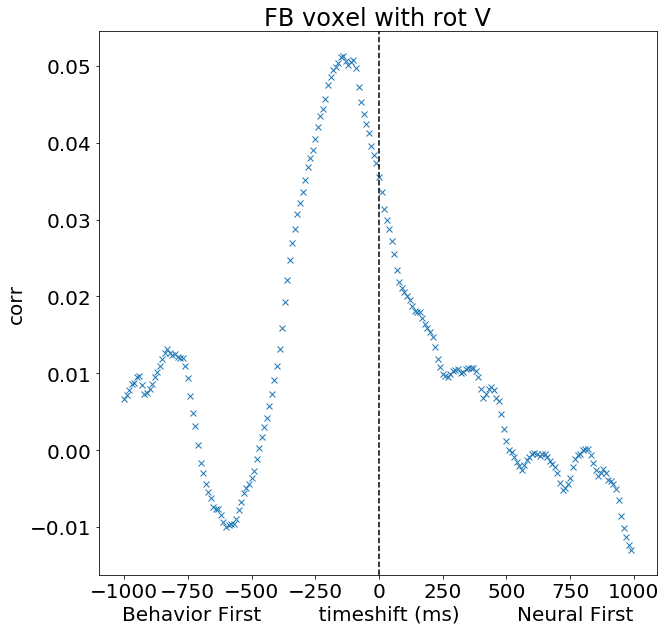

In [75]:
# negative times mean correlation of the earlier behavior with neural data
# ie, if peak is negative, this means that behavior that happens before the neural response is correlated
# ie, the neural data lags behind.
# if there is a peak to the right, that means the neural data best correlates with what is about to happen.

plt.figure(figsize=(10,10))
plt.plot(cross_corr_shifts, fictrac_shifts,'x')
plt.axvline(0,color='k',linestyle='--')
#plt.axhline(0,color='k',linestyle='--')
plt.ylabel('corr')
plt.xlabel('Behavior First         timeshift (ms)         Neural First')
plt.title('FB voxel with rot V')
#plt.text(x=-400,y=0.04,s='Behavior\nFirst')

In [46]:
# create bounding boxes
forward_min = 2
forward_max = 6
forward_width = 1

rotation_min = 2
rotation_max = 12
rotation_forward_bias = 4
rotation_reverse_bias = 0

stop_r = 0.2

f1 = np.where(fictrac['Y']>forward_min)[0]
f2 = np.where(np.abs(fictrac['Z'])<forward_width)[0]
f3 = np.where(fictrac['Y']<forward_max)[0]
forward_times = [i for i in f1 if i in f2 and i in f3]

r1 = np.where(fictrac['Z']>rotation_min)[0]
r2 = np.where(fictrac['Z']<rotation_max)[0]
r3 = np.where(fictrac['Y']>rotation_reverse_bias)[0]
r4 = np.where(fictrac['Y']<rotation_forward_bias)[0]
rotation_pos_times = [i for i in r1 if i in r2 and i in r3 and i in r4]

r1 = np.where(fictrac['Z']<-rotation_min)[0]
r2 = np.where(fictrac['Z']>-rotation_max)[0]
r3 = np.where(fictrac['Y']>rotation_reverse_bias)[0]
r4 = np.where(fictrac['Y']<rotation_forward_bias)[0]
rotation_neg_times = [i for i in r1 if i in r2 and i in r3 and i in r4]

rotation_times = rotation_pos_times + rotation_neg_times

stop_times = np.where(fictrac['Y']**2 + fictrac['Z']**2 < stop_r**2)[0]

print(len(forward_times), len(rotation_pos_times), len(rotation_neg_times), len(stop_times), len(rotation_times))


185 154 9 2215 163


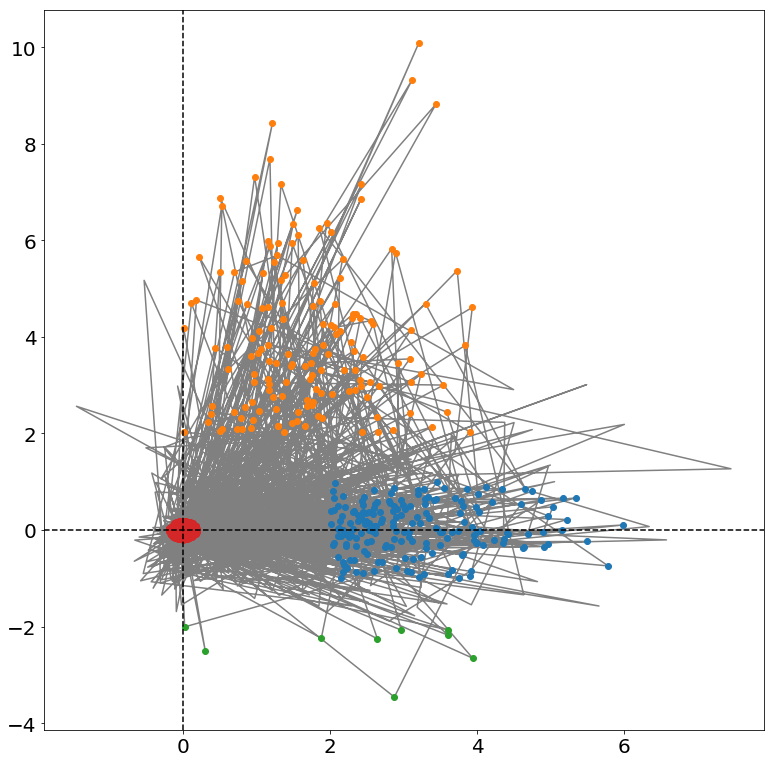

In [48]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
x=fictrac['Y']
y=fictrac['Z']
ax.plot(x,y,color='grey')
ax.plot(x[forward_times],y[forward_times],marker='o',linestyle='None')
ax.plot(x[rotation_pos_times],y[rotation_pos_times],marker='o',linestyle='None')
ax.plot(x[rotation_neg_times],y[rotation_neg_times],marker='o',linestyle='None')
ax.plot(x[stop_times],y[stop_times],marker='o',linestyle='None')


ax.axvline(0, linestyle='--', color='k')
ax.axhline(0, linestyle='--', color='k')

In [ ]:
### Straightness metric
# remove all points within large circle around stopped
# for remaining points, calculate straightness as Y-Z

# create bounding boxes
forward_min = 2
forward_max = 6
forward_width = 1

rotation_min = 2
rotation_max = 12
rotation_forward_bias = 4
rotation_reverse_bias = 0

exclude_r = 0.2

# f1 = np.where(fictrac['Y']>forward_min)[0]
# f2 = np.where(np.abs(fictrac['Z'])<forward_width)[0]
# f3 = np.where(fictrac['Y']<forward_max)[0]
# forward_times = [i for i in f1 if i in f2 and i in f3]

# r1 = np.where(fictrac['Z']>rotation_min)[0]
# r2 = np.where(fictrac['Z']<rotation_max)[0]
# r3 = np.where(fictrac['Y']>rotation_reverse_bias)[0]
# r4 = np.where(fictrac['Y']<rotation_forward_bias)[0]
# rotation_pos_times = [i for i in r1 if i in r2 and i in r3 and i in r4]

# r1 = np.where(fictrac['Z']<-rotation_min)[0]
# r2 = np.where(fictrac['Z']>-rotation_max)[0]
# r3 = np.where(fictrac['Y']>rotation_reverse_bias)[0]
# r4 = np.where(fictrac['Y']<rotation_forward_bias)[0]
# rotation_neg_times = [i for i in r1 if i in r2 and i in r3 and i in r4]

rotation_times = rotation_pos_times + rotation_neg_times

exclude_times = np.where(fictrac['Y']**2 + fictrac['Z']**2 < exclude_r**2)[0]

print(len(forward_times), len(rotation_pos_times), len(rotation_neg_times), len(stop_times), len(rotation_times))

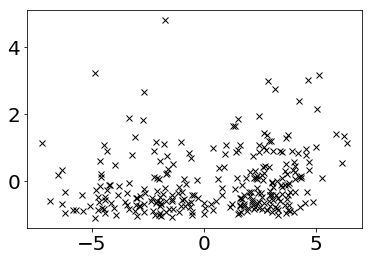

In [149]:
include_r = 3
include_times = np.where(fictrac['Y']**2 + fictrac['Z']**2 > include_r**2)[0]
straightness = fictrac['Y'][include_times]-np.abs(fictrac['Z'][include_times])
plt.plot(straightness, brain[x,y,z,include_times],linestyle='',marker='x',color='k')

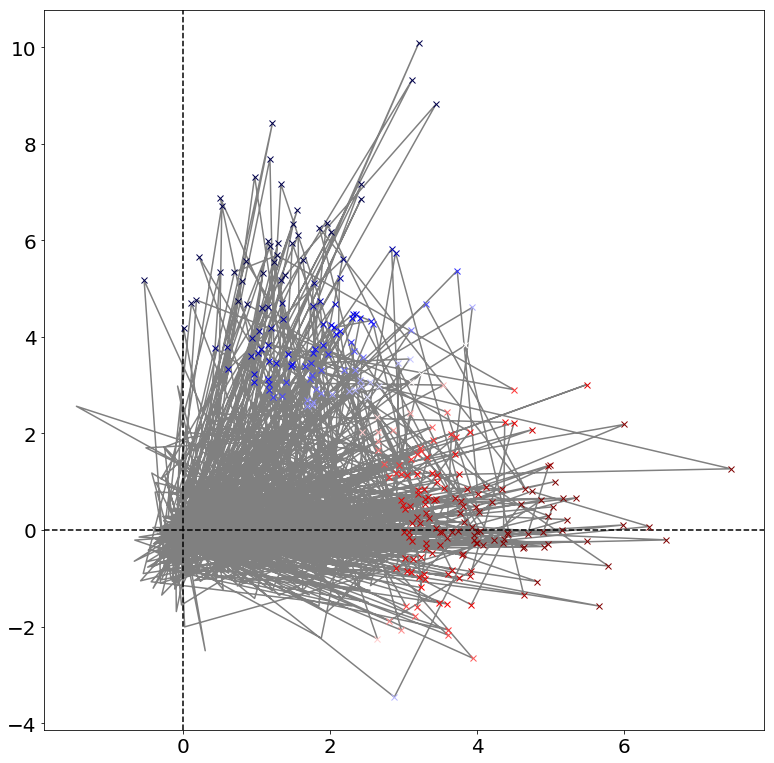

In [141]:
include_r = 3
include_times = np.where(fictrac['Y']**2 + fictrac['Z']**2 > include_r**2)[0]

fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
x=fictrac['Y']
y=fictrac['Z']
ax.plot(x,y,color='grey')
#ax.plot(x[exclude_times],y[exclude_times],marker='o',linestyle='None')

ax.axvline(0, linestyle='--', color='k')
ax.axhline(0, linestyle='--', color='k')

norm = mpl.colors.Normalize(vmin=-4, vmax=4)
cmap = cm.seismic
xss = cm.ScalarMappable(norm=norm, cmap=cmap)
for i in include_times:
    ax.plot(fictrac['Y'][i],fictrac['Z'][i],color=xss.to_rgba(fictrac['Y'][i]-np.abs(fictrac['Z'][i])),marker='x',linestyle='-')

In [321]:
np.mean(brain[x,y,z,stop_times])

-0.16881212174689736

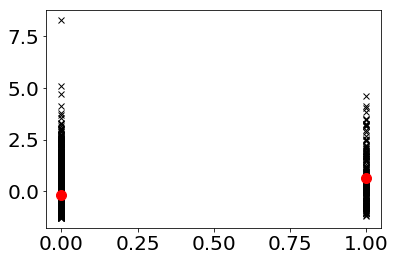

In [331]:
plt.plot([0]*len(stop_times), brain[x,y,z,stop_times],marker='x',linestyle='',color='k')
plt.plot(np.mean(brain[x,y,z,stop_times]),marker='o',color='r',markersize=10)

plt.plot([1]*len(forward_times), brain[x,y,z,forward_times],marker='x',linestyle='',color='k')
plt.plot(1, np.mean(brain[x,y,z,forward_times]),marker='o',color='r',markersize=10)

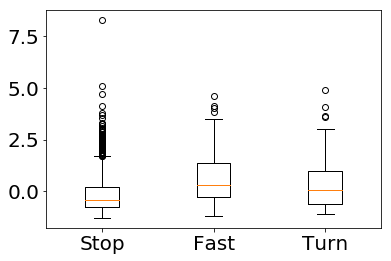

In [340]:
data_for_boxplot = [brain[x,y,z,stop_times], brain[x,y,z,forward_times],  brain[x,y,z,rotation_pos_times]]
plt.boxplot(data_for_boxplot);
plt.xticks([1, 2, 3], ['Stop', 'Fast', 'Turn']);

In [14]:
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

In [198]:
###### CURRENT BEST METHOD ######

expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

behavior = 'Yh'

B_THRESHOLD = np.std(fictrac[behavior])/4
ALIVE_TIME = 1000 # in ms
DEAD_TIME = 1000 # in ms

state = 'quiescent'
up_streak = 0
down_streak = 0
BOUTS = []
ALIVE_TIME = int(ALIVE_TIME/resolution)
DEAD_TIME = int(DEAD_TIME/resolution)

for i in range(len(fictrac[behavior])):
    # If high behavior, reset down_streak, and add 1 to up_streak
    if fictrac[behavior][i] > B_THRESHOLD:
        down_streak = 0
        up_streak += 1
    else:
        up_streak = 0
        down_streak += 1
        
    if state == 'quiescent':
        if up_streak >= ALIVE_TIME:
            state = 'moving'
            BOUTS.append({'start': i-ALIVE_TIME})
    elif state == 'moving':
        if down_streak >= DEAD_TIME:
            state = 'quiescent'
            BOUTS[-1]['end'] = i-DEAD_TIME

BOUTS = [bout for bout in BOUTS if 'end' in bout]
print('Found {} bouts'.format(len(BOUTS)))



Found 133 bouts


In [206]:
# remove bouts that have behavior too close before them
before = 4000 # in ms

before = int(before/10)
bouts=[bout for bout in BOUTS if np.mean(np.abs(fictrac['Yh'][bout['end']:bout['end']+before])) < .2]
print('Remaining bouts: {}'.format(np.shape(bouts)[0]))

Remaining bouts: 82


Text(0.5, 0, 'sec')

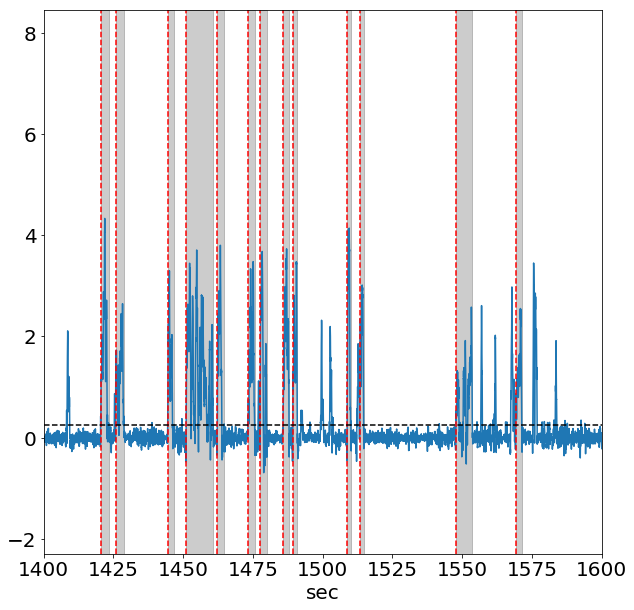

In [47]:
plt.figure(figsize=(10,10))

plt.plot(high_res_timepoints/1000, fictrac['Yh'])
#plt.plot(xnew/1000,PB_signal_highres/10)

for bout in BOUTS:
    try:
        plt.axvspan(bout['start']/100, bout['end']/100, alpha=0.2, color='k')
        plt.axvline(bout['start']/100,color='r',linestyle='--')
    except:
        pass
    
plt.axhline(B_THRESHOLD,color='k',linestyle='--')
plt.xlim(1400,1600)
plt.xlabel('sec')
#plt.xlim(808,1000)

In [201]:
# remove bouts that have behavior too close before them
before = 3000 # in ms

before = int(before/10)
bouts=[bout for bout in BOUTS if np.mean(np.abs(fictrac['Yh'][bout['start']-before:bout['start']])) < .2]
print('Remaining bouts: {}'.format(np.shape(bouts)[0]))

Remaining bouts: 104


Text(0.5, 0, 'ms')

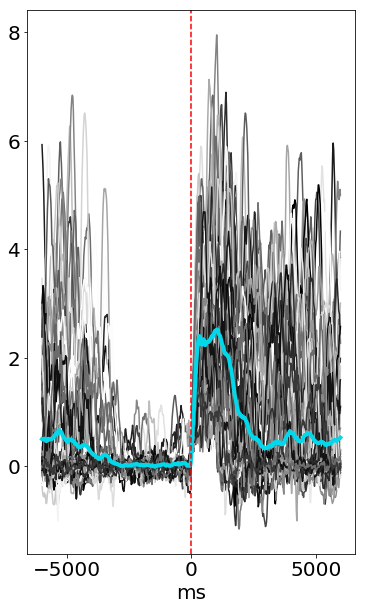

In [174]:
before = 6000 #in ms
after = 6000 #in ms

before = int(before/10) # now everything is in units of 10ms
after = int(after/10)
bins = bbb.create_bins(10,before*10,after*10)[:-1]

plt.figure(figsize=(20,10))
plt.subplot(131)
for i,bout in enumerate(bouts):
    plt.plot(bins,fictrac['Yh'][bout['start']-before:bout['start']+after],color=str(np.random.uniform()))
all_bouts = [fictrac['Yh'][bout['start']-before:bout['start']+after] for bout in bouts][1:-1]
all_bouts = np.asarray(all_bouts)
avg_bout = np.mean(all_bouts,axis=0)
plt.plot(bins,avg_bout,color='xkcd:aqua blue',linewidth=4)
plt.axvline(0,linestyle='--',color='r')
plt.xlabel('ms')
#plt.xlim(-1000,1000)

Text(0.5, 0, 'ms')

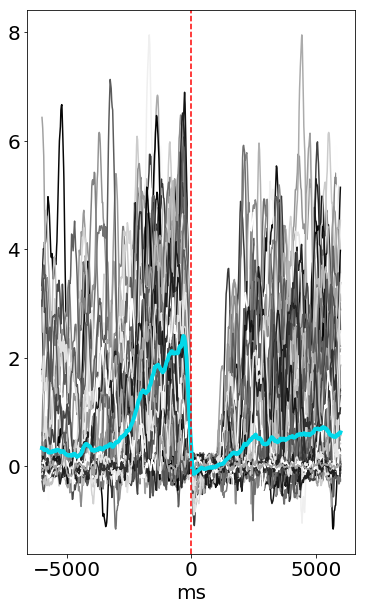

In [180]:
before = 6000 #in ms
after = 6000 #in ms

before = int(before/10) # now everything is in units of 10ms
after = int(after/10)
bins = bbb.create_bins(10,before*10,after*10)[:-1]

plt.figure(figsize=(20,10))
plt.subplot(131)
for i,bout in enumerate(bouts):
    try:
        plt.plot(bins,fictrac['Yh'][bout['end']-before:bout['end']+after],color=str(np.random.uniform()))
    except:
        pass
all_bouts = [fictrac['Yh'][bout['end']-before:bout['end']+after] for bout in bouts][1:-1]
all_bouts = np.asarray(all_bouts)
avg_bout = np.mean(all_bouts,axis=0)
plt.plot(bins,avg_bout,color='xkcd:aqua blue',linewidth=4)
plt.axvline(0,linestyle='--',color='r')
plt.xlabel('ms')
#plt.xlim(-1000,1000)

Text(0.5, 0, 'ms')

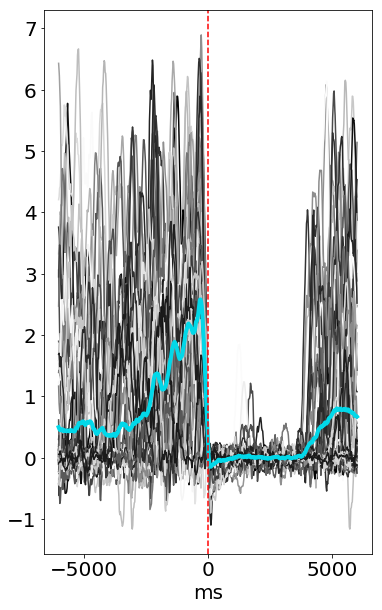

In [207]:
before = 6000 #in ms
after = 6000 #in ms

before = int(before/10) # now everything is in units of 10ms
after = int(after/10)
bins = bbb.create_bins(10,before*10,after*10)[:-1]

plt.figure(figsize=(20,10))
plt.subplot(131)
for i,bout in enumerate(bouts):
    try:
        plt.plot(bins,fictrac['Yh'][bout['end']-before:bout['end']+after],color=str(np.random.uniform()))
    except:
        pass
all_bouts = [fictrac['Yh'][bout['end']-before:bout['end']+after] for bout in bouts][1:-1]
all_bouts = np.asarray(all_bouts)
avg_bout = np.mean(all_bouts,axis=0)
plt.plot(bins,avg_bout,color='xkcd:aqua blue',linewidth=4)
plt.axvline(0,linestyle='--',color='r')
plt.xlabel('ms')
#plt.xlim(-1000,1000)

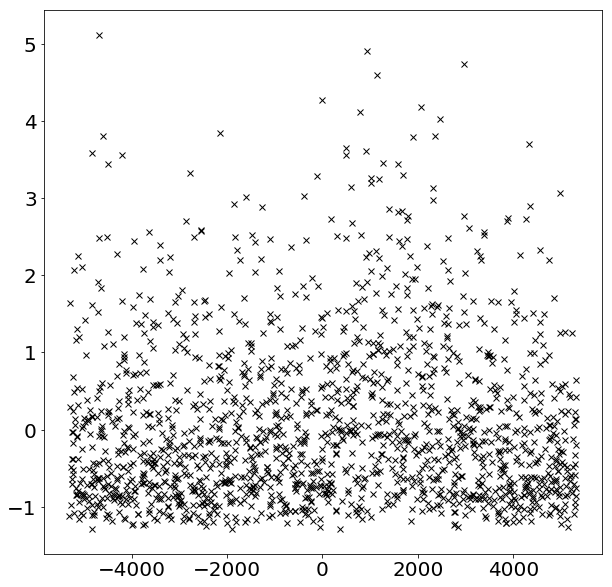

In [243]:
plt.figure(figsize=(10,10))

num_neural_points = 10
xss = []; yss = []
for i in range(len(bouts)):
    nearest = np.searchsorted(timestamps[:,z]/10, bouts[i]['start'])
    offset = (timestamps[nearest,z]/10 - bouts[i]['start'])*10
    jump = timestamps[1,0]-timestamps[0,0]
    xs = np.arange(offset-num_neural_points*jump,offset+num_neural_points*jump,jump)
    ys = brain[x,y,z,nearest-num_neural_points:nearest+num_neural_points]
    plt.plot(xs,ys,marker='x',linestyle='',color='k')
    xss.append(xs); yss.append(ys)
xss = np.asarray(xss); yss = np.asarray(yss)

bin_id = np.digitize(xss.ravel(), np.arange(-5000,5000,100))
avgs = []
for i in range(len(bin_id)):
    avgs.append(np.mean(yss.ravel()[np.where(bin_id==i)[0]]))

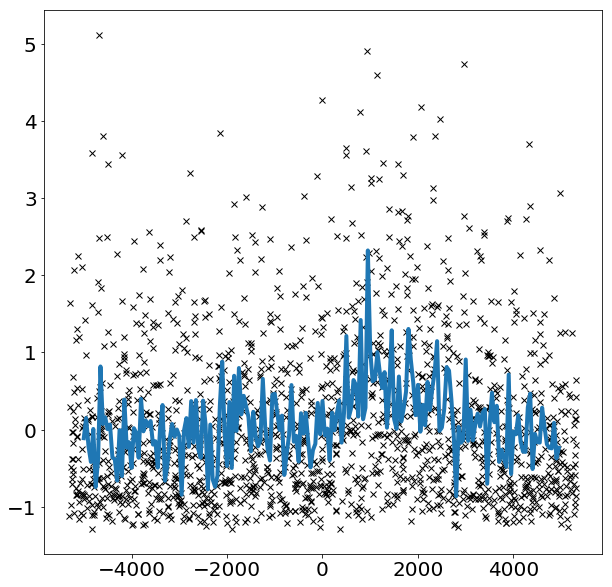

In [284]:
plt.figure(figsize=(10,10))

num_neural_points = 10
xss = []; yss = []
for i in range(len(bouts)):
    nearest = np.searchsorted(timestamps[:,z]/10, bouts[i]['start'])
    offset = (timestamps[nearest,z]/10 - bouts[i]['start'])*10
    jump = timestamps[1,0]-timestamps[0,0]
    xs = np.arange(offset-num_neural_points*jump,offset+num_neural_points*jump,jump)
    ys = brain[x,y,z,nearest-num_neural_points:nearest+num_neural_points]
    plt.plot(xs,ys,marker='x',linestyle='',color='k')
    xss.append(xs); yss.append(ys)
xss = np.asarray(xss); yss = np.asarray(yss)

bins = np.arange(-5000,5000,50)
bin_id = np.digitize(xss.ravel(), bins)
avgs = []
for i in range(len(bins)):
    avgs.append(np.mean(yss.ravel()[np.where(bin_id==i)[0]]))
    
plt.plot(bins,avgs,linewidth=4)

In [285]:
bins

array([-5000, -4950, -4900, -4850, -4800, -4750, -4700, -4650, -4600,
       -4550, -4500, -4450, -4400, -4350, -4300, -4250, -4200, -4150,
       -4100, -4050, -4000, -3950, -3900, -3850, -3800, -3750, -3700,
       -3650, -3600, -3550, -3500, -3450, -3400, -3350, -3300, -3250,
       -3200, -3150, -3100, -3050, -3000, -2950, -2900, -2850, -2800,
       -2750, -2700, -2650, -2600, -2550, -2500, -2450, -2400, -2350,
       -2300, -2250, -2200, -2150, -2100, -2050, -2000, -1950, -1900,
       -1850, -1800, -1750, -1700, -1650, -1600, -1550, -1500, -1450,
       -1400, -1350, -1300, -1250, -1200, -1150, -1100, -1050, -1000,
        -950,  -900,  -850,  -800,  -750,  -700,  -650,  -600,  -550,
        -500,  -450,  -400,  -350,  -300,  -250,  -200,  -150,  -100,
         -50,     0,    50,   100,   150,   200,   250,   300,   350,
         400,   450,   500,   550,   600,   650,   700,   750,   800,
         850,   900,   950,  1000,  1050,  1100,  1150,  1200,  1250,
        1300,  1350,

(-1.5, 4)

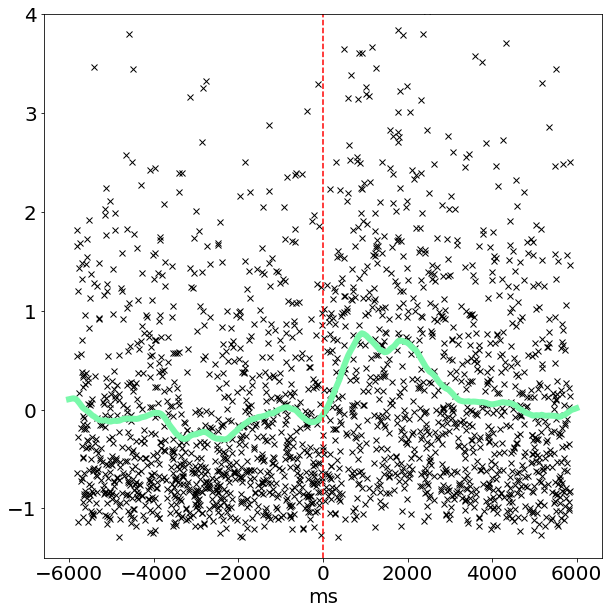

In [172]:
plt.figure(figsize=(10,10))


before = 6000 #in ms
after = 6000 # in ms
num_neural_points = int(before/jump)

before = int(before/10) # now everything is in units of 10ms
after = int(after/10)
bins = bbb.create_bins(10,before*10,after*10)[:-1]

neural_data = brain[x,y,z,:]
temp_interp = interp1d(timestamps[:,z], neural_data, bounds_error = False)
neural_highres = temp_interp(high_res_timepoints)


bout_triggered_neural = [neural_highres[bout['start']-before:bout['start']+after] for bout in bouts][1:-1]
avg_neural = np.mean(bout_triggered_neural,axis=0)

for i in range(len(bouts)):
    nearest = np.searchsorted(timestamps[:,z]/10, bouts[i]['start'])
    offset = (timestamps[nearest,z]/10 - bouts[i]['start'])*10
    jump = timestamps[1,0]-timestamps[0,0]
    xs = np.arange(offset-num_neural_points*jump,offset+num_neural_points*jump,jump)
    plt.plot(xs,brain[x,y,z,nearest-num_neural_points:nearest+num_neural_points],marker='x',linestyle='',color='k')

plt.plot(bins,avg_neural,color='xkcd:seafoam green',linewidth=6)
plt.axvline(0,linestyle='--',color='r')
plt.xlabel('ms')

#plt.xlim(-300,300)
plt.ylim(-1.5,4)

In [65]:
plt.figure(figsize=(10,10))


before = 6000 #in ms
after = 6000 # in ms
before = int(before/10) # now everything is in units of 10ms
after = int(after/10)
bins = bbb.create_bins(10,before*10,after*10)[:-1]

neural_data = brain[x,y,z,:]
temp_interp = interp1d(timestamps[:,z], neural_data, bounds_error = False)
neural_highres = temp_interp(high_res_timepoints)


bout_triggered_neural = [neural_highres[bout['start']-before:bout['start']+after] for bout in bouts][1:-1]
#bout_triggered_PB_R_normalized=bout_triggered_PB_R
#bout_triggered_neural_normalized = [(bout-np.mean(bout[:200]))/np.mean(bout[:200]) for bout in bout_triggered_neural]
avg_neural = np.mean(bout_triggered_neural,axis=0)

for i in range(len(bouts)):
    try:
        plt.plot(bins,bout_triggered_neural[i],color=str(np.random.uniform()))
    except:
        pass
plt.plot(bins,avg_neural,color='xkcd:seafoam green',linewidth=6)
plt.axvline(0,linestyle='--',color='r')
plt.xlabel('ms')


plt.axvline(0,linestyle='--',color='r')
plt.xlabel('ms')

#plt.xlim(-300,300)
#plt.ylim(-1,1)

(93, 600)

In [251]:
num_bins_x, num_bins_y = 10, 10
start_x, end_x = -1, 6
start_y, end_y = -2, 5

#start_x, end_x = -10, 15
#start_y, end_y = -130, 130

# Define bins
bins_x, bins_y = np.linspace(start_x,end_x,num_bins_x), np.linspace(start_y,end_y,num_bins_y)

# Assign fictrac values to bin numbers
idx_x, idx_y = np.digitize(fictrac['Y'],bins_x), np.digitize(fictrac['Z'],bins_y)

test = bin_pc(brain[x,y,z,:], num_bins_x, num_bins_y, idx_x ,idx_y)

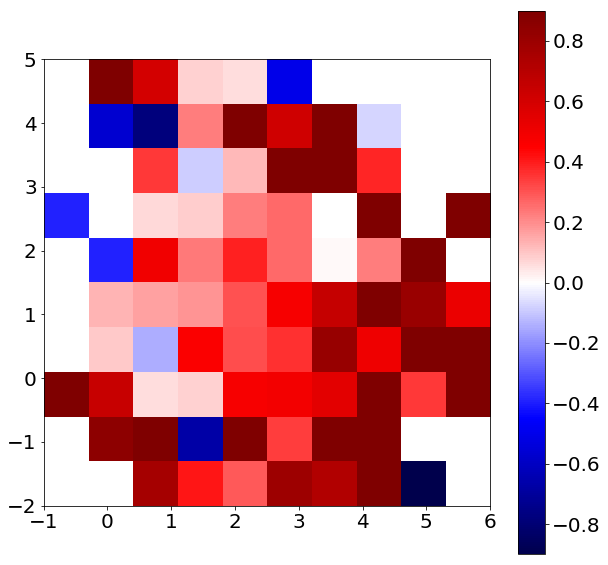

In [256]:
fig = plt.figure(figsize=(10,10))
plt.imshow(test['pc_binned'],cmap='seismic',extent=(start_x,end_x,start_y,end_y),vmin=-.9,vmax=.9)
plt.colorbar()

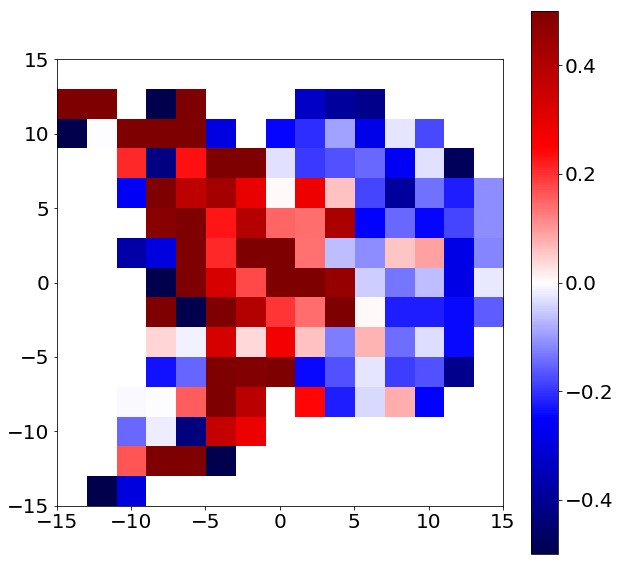

In [249]:
fig = plt.figure(figsize=(10,10))
plt.imshow(test['pc_binned'],cmap='seismic',extent=(start_x,end_x,start_y,end_y),vmin=-.5,vmax=.5)
plt.colorbar()

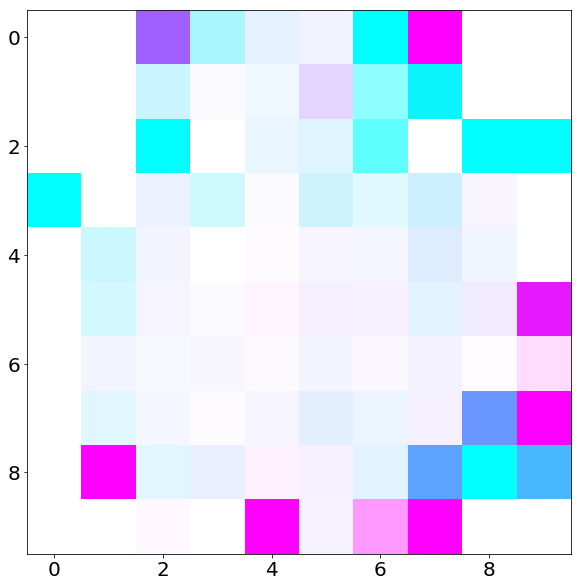

In [174]:
fig = plt.figure(figsize=(10,10))

alphas = Normalize(.5, 10, clip=True)(1/test['pc_std'])
alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
# Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
colors = Normalize(-.7, .7)(test['pc_binned'])
cmap = plt.cm.cool
colors = cmap(colors)
# Now set the alpha channel to the one we created above
colors[..., -1] = alphas
plt.imshow(colors)

In [ ]:
num_bins_x, num_bins_y = 10, 10
start_x, end_x = -1, 6
start_y, end_y = -2, 5

#start_x, end_x = -10, 15
#start_y, end_y = -130, 130

# Define bins
bins_x, bins_y = np.linspace(start_x,end_x,num_bins_x), np.linspace(start_y,end_y,num_bins_y)

# Assign fictrac values to bin numbers
idx_x, idx_y = np.digitize(fictrac['Y'],bins_x), np.digitize(fictrac['Z'],bins_y)

test = bin_pc(brain[x,y,z,:], num_bins_x, num_bins_y, idx_x ,idx_y)



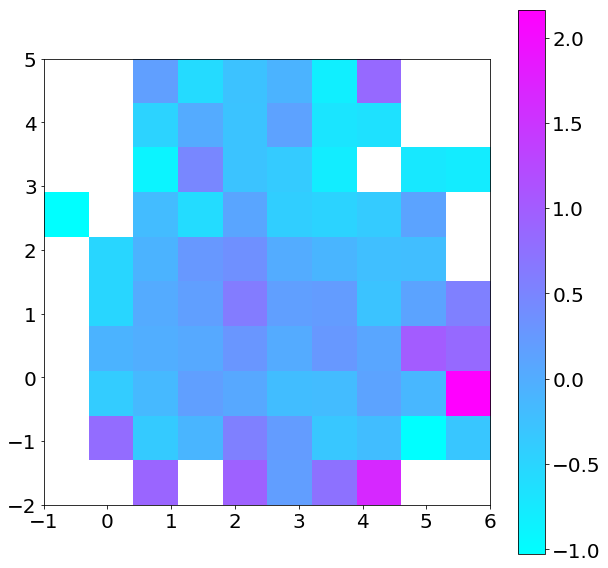

In [172]:
fig = plt.figure(figsize=(10,10))
plt.imshow(test['pc_binned'],cmap='cool',extent=(start_x,end_x,start_y,end_y))
plt.colorbar()

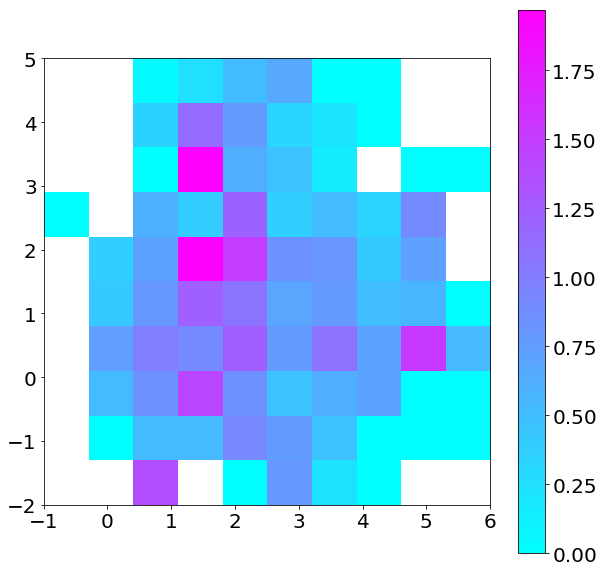

In [173]:
fig = plt.figure(figsize=(10,10))
plt.imshow(test['pc_std'],cmap='cool',extent=(start_x,end_x,start_y,end_y))
plt.colorbar()

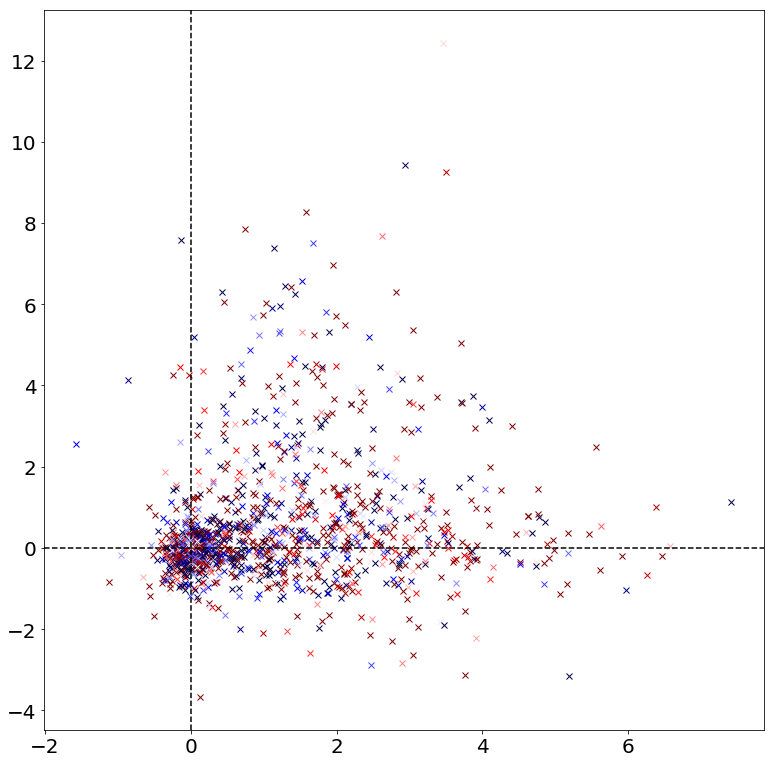

In [254]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])

norm = mpl.colors.Normalize(vmin=-.7, vmax=.7)
cmap = cm.seismic
xss = cm.ScalarMappable(norm=norm, cmap=cmap)
#ax.imshow(test['pc_binned'],cmap='cool',extent=(start_x,end_x,start_y,end_y))

for i in range(3384):
    ax.plot(fictrac['Y'][i],fictrac['Z'][i],color=xss.to_rgba(brain[x,y,z,i]),marker='x',linestyle='-')

ax.axvline(0, linestyle='--', color='k')
ax.axhline(0, linestyle='--', color='k')

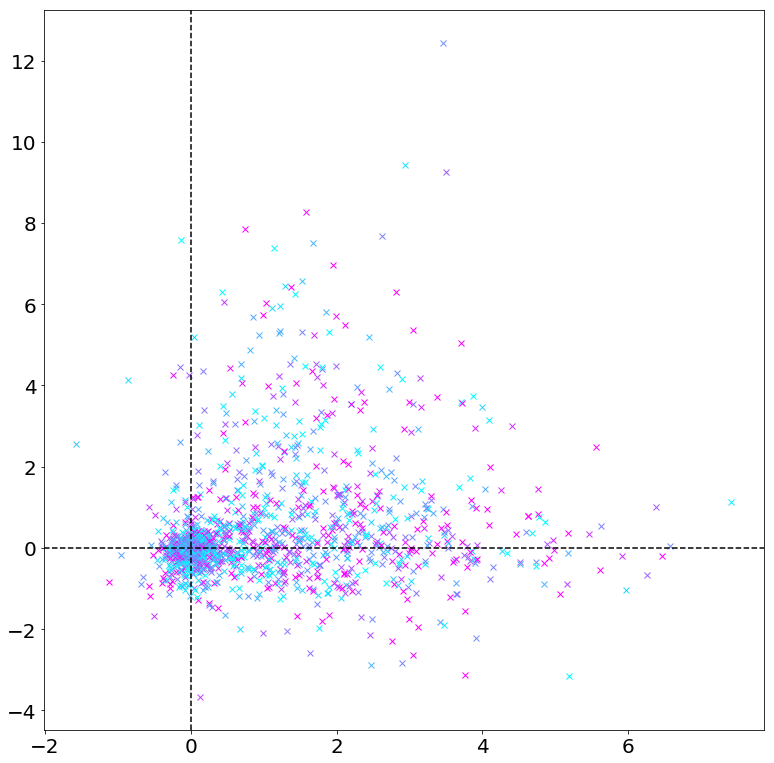

In [253]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])

norm = mpl.colors.Normalize(vmin=np.percentile(brain[x,y,z,:],10), vmax=np.percentile(brain[x,y,z,:],90))
cmap = cm.cool
xss = cm.ScalarMappable(norm=norm, cmap=cmap)
#ax.imshow(test['pc_binned'],cmap='cool',extent=(start_x,end_x,start_y,end_y))

for i in range(3384):
    ax.plot(fictrac['Y'][i],fictrac['Z'][i],color=xss.to_rgba(brain[x,y,z,i]),marker='x',linestyle='-')

ax.axvline(0, linestyle='--', color='k')
ax.axhline(0, linestyle='--', color='k')

In [258]:
num_bins_x, num_bins_y = 15, 15
start_x, end_x = -15, 15
start_y, end_y = -15, 15

#start_x, end_x = -10, 15
#start_y, end_y = -130, 130

# Define bins
bins_x, bins_y = np.linspace(start_x,end_x,num_bins_x), np.linspace(start_y,end_y,num_bins_y)

# Assign fictrac values to bin numbers
idx_x, idx_y = np.digitize(umap_x,bins_x), np.digitize(umap_y,bins_y)

test = bin_pc(brain[x,y,z,:], num_bins_x, num_bins_y, idx_x ,idx_y)

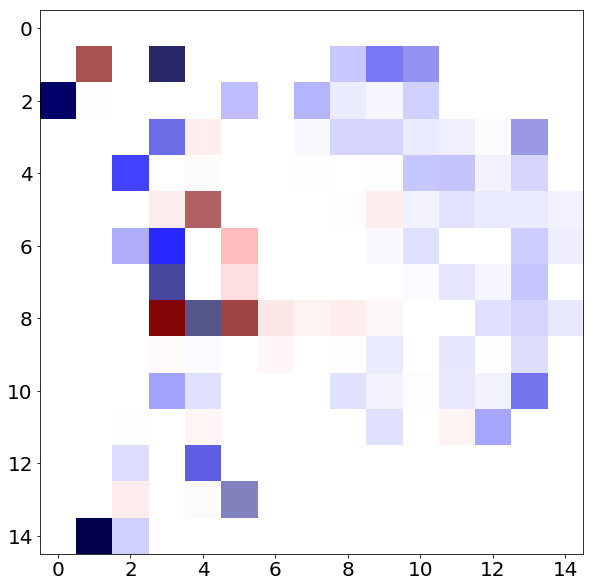

In [246]:
fig = plt.figure(figsize=(10,10))

alphas = Normalize(-1, 0, clip=True)(-test['pc_std'])
alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
# Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
colors = Normalize(-.7, .7)(test['pc_binned'])
cmap = plt.cm.seismic
colors = cmap(colors)
# Now set the alpha channel to the one we created above
colors[..., -1] = alphas
plt.imshow(colors)

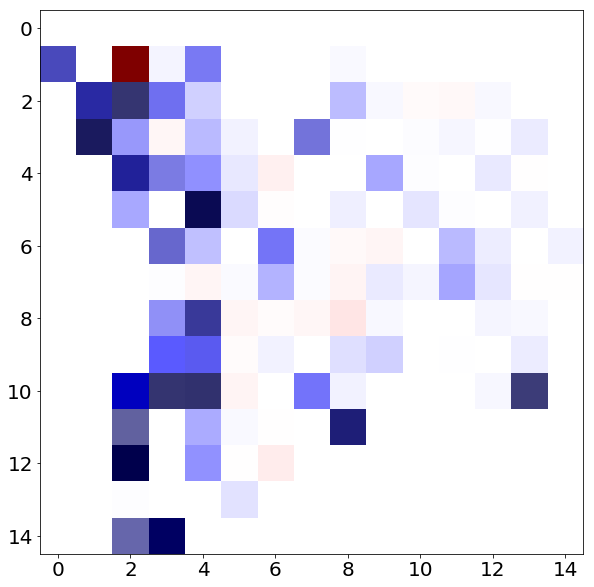

In [224]:
fig = plt.figure(figsize=(10,10))

alphas = Normalize(-1, 0, clip=True)(-test['pc_std'])
alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
# Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
colors = Normalize(-.7, .7)(test['pc_binned'])
cmap = plt.cm.seismic
colors = cmap(colors)
# Now set the alpha channel to the one we created above
colors[..., -1] = alphas
plt.imshow(colors)

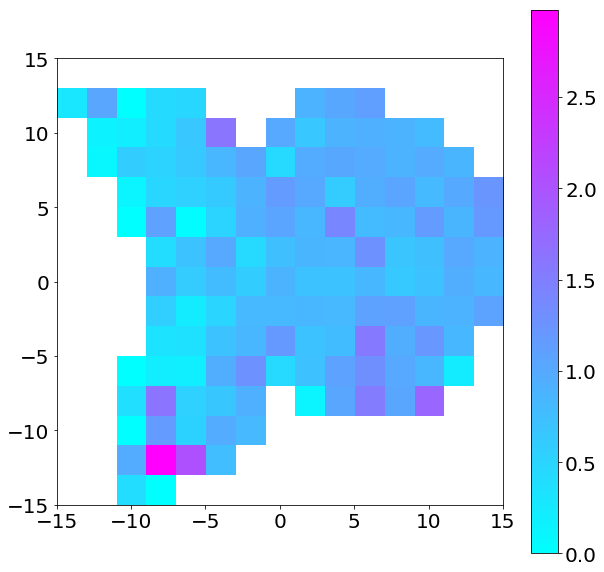

In [137]:
fig = plt.figure(figsize=(10,10))
plt.imshow(test['pc_std'],cmap='cool',extent=(start_x,end_x,start_y,end_y))
plt.colorbar()

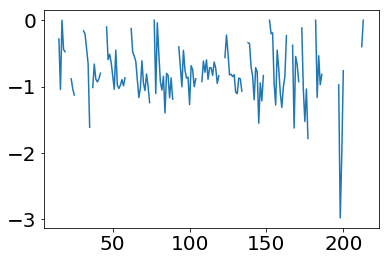

In [209]:
plt.plot(-test['pc_std'].ravel())

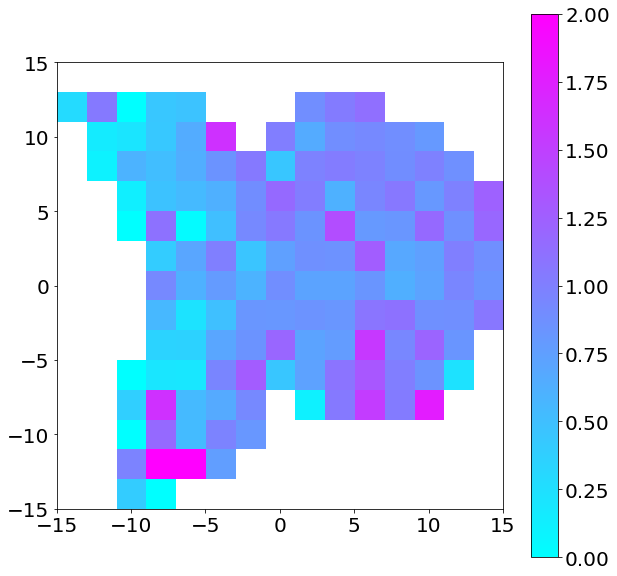

In [134]:
fig = plt.figure(figsize=(10,10))
plt.imshow(test['pc_std'],cmap='cool',extent=(start_x,end_x,start_y,end_y),vmax=2)
plt.colorbar()

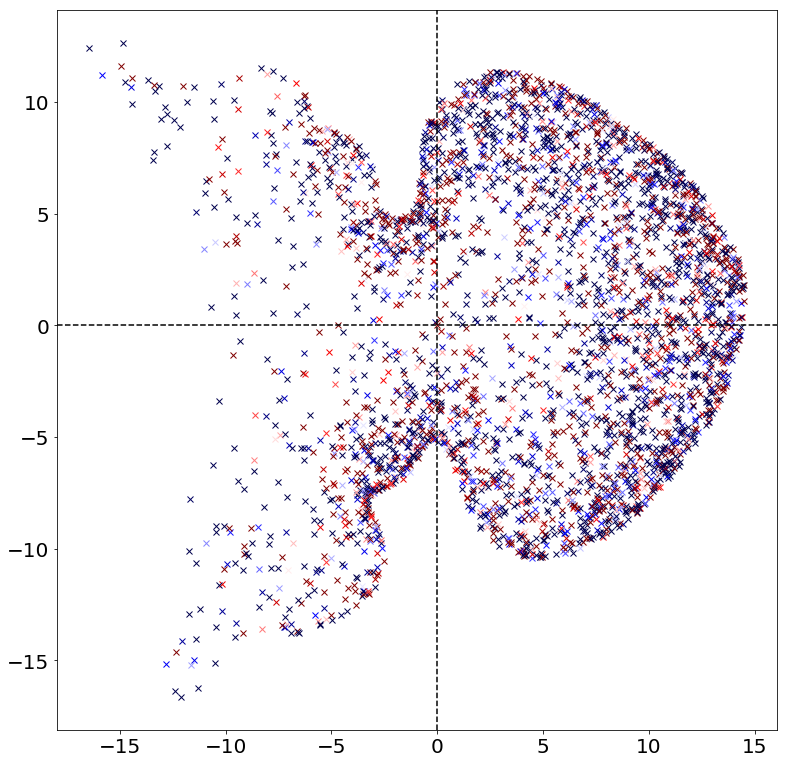

In [41]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])

norm = mpl.colors.Normalize(vmin=-.5, vmax=.5)
cmap = cm.seismic
xss = cm.ScalarMappable(norm=norm, cmap=cmap)

for i in range(3384):
    ax.plot(umap_x[i],umap_y[i],color=xss.to_rgba(brain[x,y,z,i]),marker='x',linestyle='-')

ax.axvline(0, linestyle='--', color='k')
ax.axhline(0, linestyle='--', color='k')

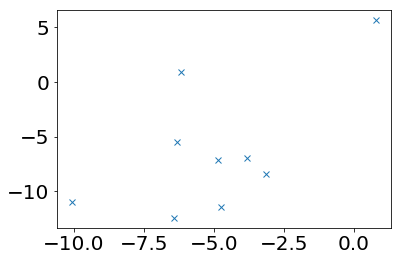

In [49]:
plt.plot(umap_x[rotation_neg_times], umap_y[rotation_neg_times],'x')

In [240]:
np.percentile(brain[x,y,z,:],10)

-0.928985595703125

In [241]:
np.percentile(brain[x,y,z,:],90)

1.3673397779464727

(array([1.606e+03, 1.055e+03, 4.560e+02, 1.860e+02, 5.400e+01, 2.100e+01,
        5.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-1.29017448, -0.33280802,  0.62455845,  1.58192492,  2.53929138,
         3.49665785,  4.45402431,  5.41139078,  6.36875725,  7.32612371,
         8.28349018]),
 <a list of 10 Patch objects>)

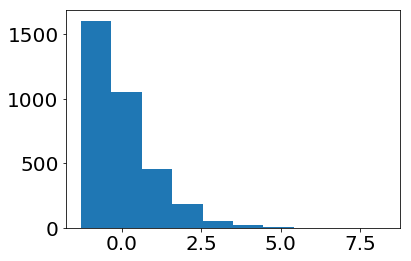

In [243]:
plt.hist(brain[x,y,z,:])

In [245]:
np.mean(brain[x,y,z,:])

-3.594852847445659e-08

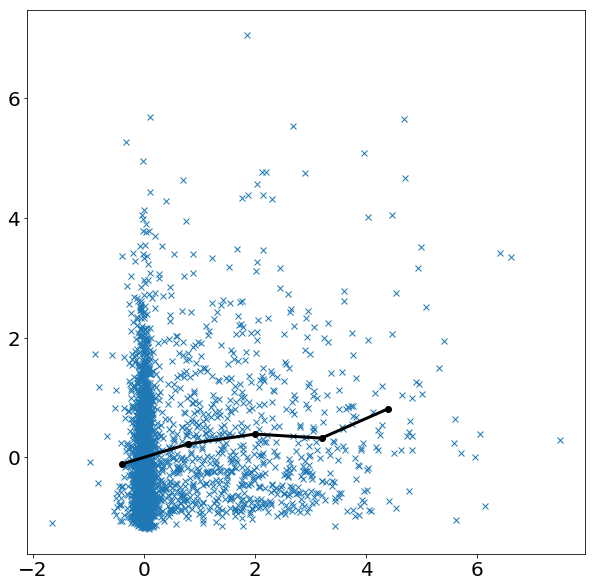

In [47]:

binned = scipy.stats.binned_statistic(x=fictrac['Y'], values=brain[x,y,z,:], statistic='mean', bins=5, range=(-1,5))
centers = (binned.bin_edges[:-1] + binned.bin_edges[1:]) / 2

fig = plt.figure(figsize=(10,10))
plt.plot(fictrac['Y'],brain[x,y,z,:],'x')
plt.plot(centers,binned.statistic,color='k',linewidth=3,marker='o')
#plt.text(x=-6,y=.6,s='FB Voxel activity',rotation=90)
#plt.xlabel('forward acel')
#plt.title('medulla voxel')

In [86]:
w = 1
test = brain[x-w:x+w+1,y-w:y+w+1,z-w:z+w+1,:]
out = np.mean(test,axis=(0,1,2))

(1000, 1500)

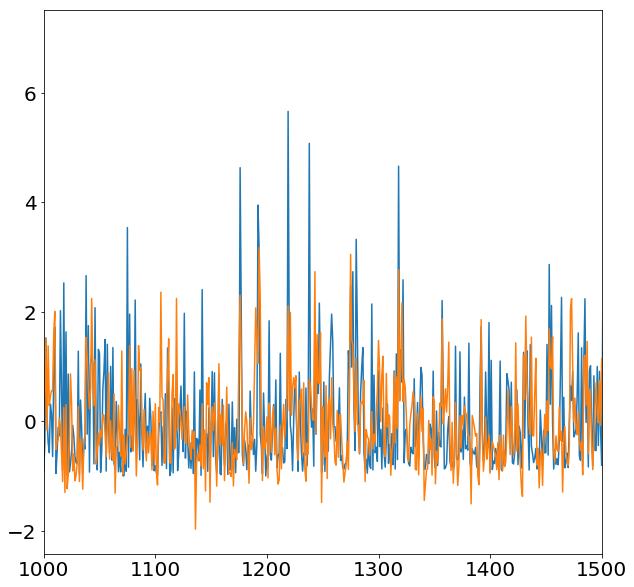

In [68]:
fig = plt.figure(figsize=(10,10))
plt.plot(brain[x,y,z,:])
plt.plot(out*2)
#plt.plot(brain[x-1,y,z,:])
#plt.plot(fictrac['Y'])
plt.xlim(1000,1500)